In [ ]:
import zipfile

zip_path = "C:/DIP_Project/BraTS-Africa.zip"
extract_to = "C:/DIP_Project/BraTS-Africa"  # Change to your desired directory

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to {extract_to}")


: 

In [6]:
!pip install nibabel


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import gzip
import shutil
import nibabel as nib
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler

# Base directory containing your data
base_dir = "C:/DIP_Project/BraTS-Africa/BraTS-Africa"  # Update with your base directory
extracted_dir = "C:/DIP_Project/BraTS-Africa/Extracted1"  # Directory where extracted files will be saved

# Create directory if it does not exist
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Function to extract .gz files
def extract_gz(file_path, destination_dir):
    """Extracts a .gz file and returns the path to the extracted file."""
    if file_path.endswith('.gz'):
        output_path = os.path.join(destination_dir, os.path.basename(file_path).replace('.gz', ''))
        with gzip.open(file_path, 'rb') as f_in:
            with open(output_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Extracted {file_path} to {output_path}")
        return output_path
    return file_path  # If not a .gz file, return the original path

# Function to find and extract .gz files in a directory
def extract_files_in_directory(patient_path, destination_dir):
    extracted_files = {}
    for file in os.listdir(patient_path):
        if file.endswith('.gz'):
            file_path = os.path.join(patient_path, file)
            extracted_file_path = extract_gz(file_path, destination_dir)
            extracted_files[file.replace('.gz', '')] = extracted_file_path
    return extracted_files

# Function to load and normalize NIfTI files
def load_and_normalize_nifti(file_path):
    if file_path is None:
        print("Warning: Attempted to load a None file path.")
        return None
    nifti_img = nib.load(file_path)
    img_data = nifti_img.get_fdata()
    scaler = MinMaxScaler()
    img_data = scaler.fit_transform(img_data.reshape(-1, img_data.shape[-1])).reshape(img_data.shape)
    return img_data

# Function to find files with a specific suffix in the extracted files
def find_extracted_file(extracted_files, suffix):
    for filename, path in extracted_files.items():
        if suffix in filename:
            return path
    return None

# Loop through patient directories and process files
for category_dir in ["51_OtherNeoplasms", "95_Glioma"]:
    category_path = os.path.join(base_dir, category_dir)
    
    # Check if category directory exists
    if not os.path.exists(category_path):
        print(f"Category path '{category_path}' does not exist. Skipping...")
        continue

    # Loop through patient folders within each category
    for patient_folder in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient_folder)
        if os.path.isdir(patient_path):
            # Extract files to a new directory
            extraction_path = os.path.join(extracted_dir, patient_folder)
            if not os.path.exists(extraction_path):
                os.makedirs(extraction_path)
            
            # Extract .gz files in the patient folder
            extracted_files = extract_files_in_directory(patient_path, extraction_path)
            
            # Dynamically find the required images based on suffixes
            flair_img = load_and_normalize_nifti(find_extracted_file(extracted_files, '-t2f.nii'))
            t1ce_img = load_and_normalize_nifti(find_extracted_file(extracted_files, '-t1c.nii'))
            t1_img = load_and_normalize_nifti(find_extracted_file(extracted_files, '-t1n.nii'))
            t2_img = load_and_normalize_nifti(find_extracted_file(extracted_files, '-t2w.nii'))
            seg_img = load_and_normalize_nifti(find_extracted_file(extracted_files, '-seg.nii'))

            # Check if all images were loaded successfully
            if not all([img is not None for img in [flair_img, t1ce_img, t1_img, t2_img, seg_img]]):
                print(f"Missing files for patient folder: {patient_folder} in category {category_dir}")
                continue

            # Resize images (optional processing)
            def resize_and_prepare(img, img_size=128):
                slices = []
                for i in range(img.shape[2]):
                    resized_slice = cv2.resize(img[:, :, i], (img_size, img_size))
                    slices.append(resized_slice)
                return np.array(slices)

            flair_resized = resize_and_prepare(flair_img)
            t1ce_resized = resize_and_prepare(t1ce_img)
            t1_resized = resize_and_prepare(t1_img)
            t2_resized = resize_and_prepare(t2_img)
            seg_resized = resize_and_prepare(seg_img)

            # Stack images for model input (example: 4-channel input for U-Net)
            X = np.stack([flair_resized, t1ce_resized, t1_resized, t2_resized], axis=-1)
            Y = np.expand_dims(seg_resized, axis=-1)

            print(f"Processed patient folder: {patient_folder} in category {category_dir}")
            print(f"Input shape: {X.shape}, Segmentation shape: {Y.shape}")

            # Further processing or model training can go here


Extracted C:\Users\manoj\Downloads\BraTS-Africa\BraTS-Africa\51_OtherNeoplasms\BraTS-SSA-00009-000\BraTS-SSA-00009-000-seg.nii.gz to C:\Users\manoj\Downloads\BraTS-Africa\Extracted1\BraTS-SSA-00009-000\BraTS-SSA-00009-000-seg.nii
Extracted C:\Users\manoj\Downloads\BraTS-Africa\BraTS-Africa\51_OtherNeoplasms\BraTS-SSA-00009-000\BraTS-SSA-00009-000-t1c.nii.gz to C:\Users\manoj\Downloads\BraTS-Africa\Extracted1\BraTS-SSA-00009-000\BraTS-SSA-00009-000-t1c.nii
Extracted C:\Users\manoj\Downloads\BraTS-Africa\BraTS-Africa\51_OtherNeoplasms\BraTS-SSA-00009-000\BraTS-SSA-00009-000-t1n.nii.gz to C:\Users\manoj\Downloads\BraTS-Africa\Extracted1\BraTS-SSA-00009-000\BraTS-SSA-00009-000-t1n.nii
Extracted C:\Users\manoj\Downloads\BraTS-Africa\BraTS-Africa\51_OtherNeoplasms\BraTS-SSA-00009-000\BraTS-SSA-00009-000-t2f.nii.gz to C:\Users\manoj\Downloads\BraTS-Africa\Extracted1\BraTS-SSA-00009-000\BraTS-SSA-00009-000-t2f.nii
Extracted C:\Users\manoj\Downloads\BraTS-Africa\BraTS-Africa\51_OtherNeoplasms\B

ImageFileError: Empty file: 'C:/Users/manoj/Downloads/BraTS-Africa/Extracted1/BraTS-SSA-00230-000/BraTS-SSA-00230-000-t2w.nii'

Epoch 1/50
16/16 [==============================] - 20s 1s/step - loss: 0.5937 - accuracy: 0.8796 - val_loss: 0.3917 - val_accuracy: 0.9791
Epoch 2/50
16/16 [==============================] - 16s 987ms/step - loss: 0.2669 - accuracy: 0.9779 - val_loss: 0.1369 - val_accuracy: 0.9791
Epoch 3/50
16/16 [==============================] - 15s 966ms/step - loss: 0.1080 - accuracy: 0.9779 - val_loss: 0.0561 - val_accuracy: 0.9791
Epoch 4/50
16/16 [==============================] - 16s 974ms/step - loss: 0.0443 - accuracy: 0.9779 - val_loss: 0.0280 - val_accuracy: 0.9791
Epoch 5/50
16/16 [==============================] - 15s 963ms/step - loss: 0.0270 - accuracy: 0.9779 - val_loss: 0.0220 - val_accuracy: 0.9791
Epoch 6/50
16/16 [==============================] - 15s 962ms/step - loss: 0.0236 - accuracy: 0.9779 - val_loss: 0.0211 - val_accuracy: 0.9791
Epoch 7/50
16/16 [==============================] - 15s 966ms/step - loss: 0.0238 - accuracy: 0.9779 - val_loss: 0.0246 - val_accuracy: 0.9791
Ep

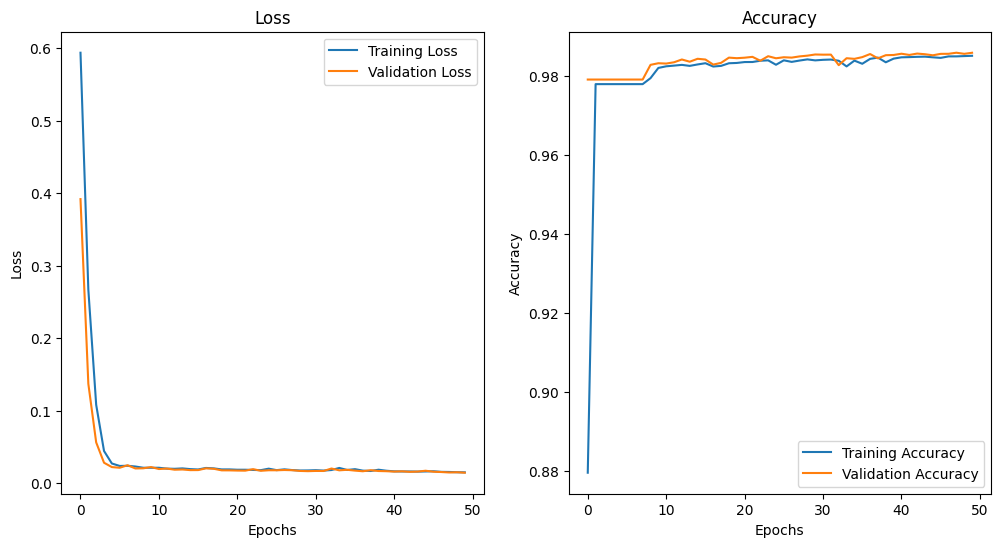

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam


# U-Net Model Definition
def build_unet_model(input_shape=(128, 128, 4)):
    inputs = Input(input_shape)
    
    # Downsampling
    c1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(p4)
    c5 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(c5)
    c5 = Dropout(0.5)(c5)
    
    # Upsampling
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4], axis=-1)
    c6 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(u6)
    c6 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3], axis=-1)
    c7 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(u7)
    c7 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2], axis=-1)
    c8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u8)
    c8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1], axis=-1)
    c9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(u9)
    c9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c9)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build and compile the U-Net model
unet_model = build_unet_model()

# Assuming your processed data (X and Y) is ready
# Splitting data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Training the model
history = unet_model.fit(X_train, Y_train, 
                         validation_data=(X_val, Y_val), 
                         epochs=50, 
                         batch_size=8, 
                         verbose=1)

# Save the trained model
unet_model.save("brain_tumor_segmentation_unet1.h5")

# Evaluate the model
loss, accuracy = unet_model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Optional: Plotting training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


1/1 [==============================] - 0s 300ms/step


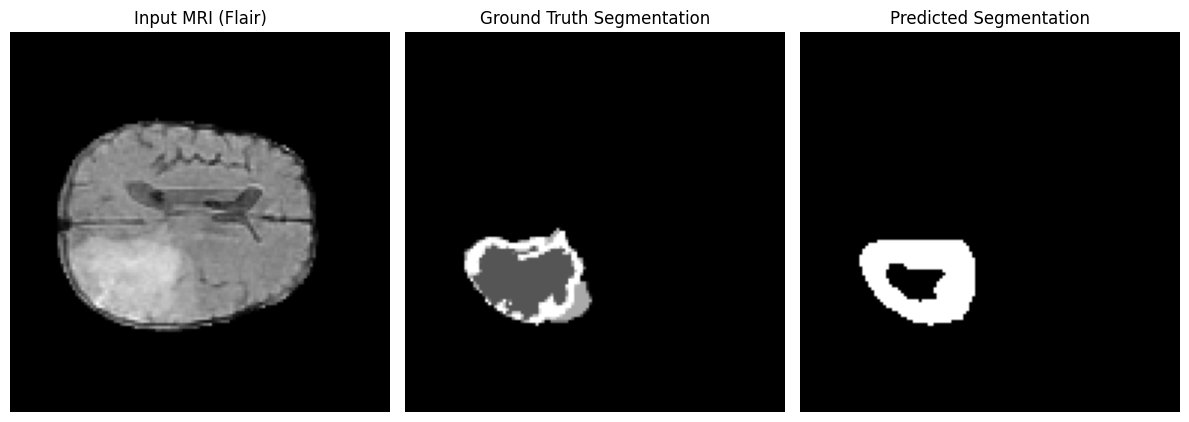

In [10]:
# Load the trained model if it's not already in memory
from tensorflow.keras.models import load_model

# Assuming you saved the model previously
unet_model = load_model("brain_tumor_segmentation_unet1.h5", compile=False)

# Load an example input for prediction
# Make sure to use appropriate data from your dataset; here, we use X_val as an example.
sample_input = X_val[0:1]  # Take the first sample from validation data for prediction

# Perform prediction
predicted_mask = unet_model.predict(sample_input)

# Post-process the output mask (e.g., thresholding if necessary)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Binarizing the output mask

# Visualize the input and predicted mask
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Display input MRI slices (example: channel 0 - flair)
plt.subplot(1, 3, 1)
plt.imshow(sample_input[0, :, :, 0], cmap='gray')  # Display first channel (e.g., flair)
plt.title('Input MRI (Flair)')
plt.axis('off')

# Display ground truth segmentation
plt.subplot(1, 3, 2)
plt.imshow(Y_val[0, :, :, 0], cmap='gray')
plt.title('Ground Truth Segmentation')
plt.axis('off')

# Display predicted segmentation
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted Segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 105ms/step


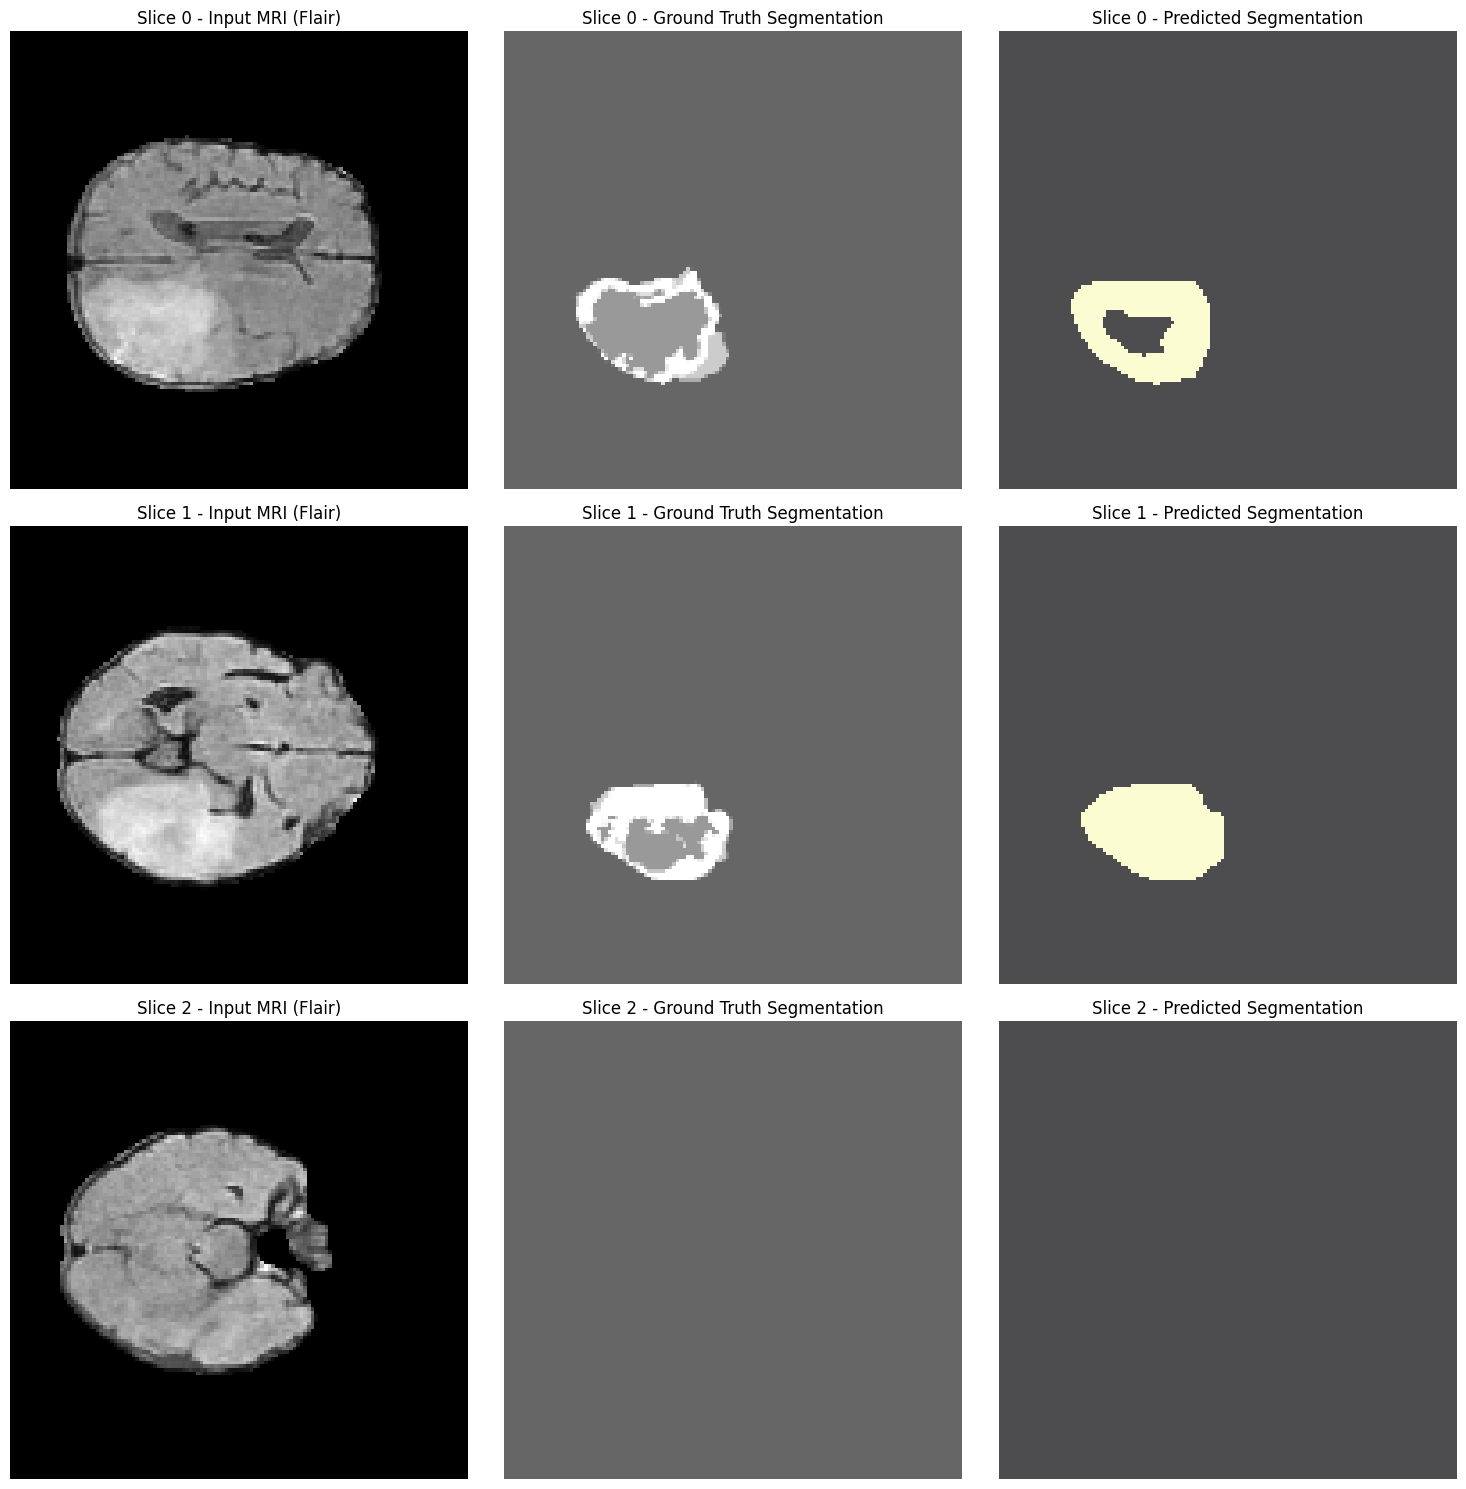

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define a function to display predictions with enhanced visualization
def display_predictions(input_mri, ground_truth, predicted_mask, slice_indices=None, colormap='viridis'):
    """
    Display predictions for multiple slices with enhanced visualization.
    
    Parameters:
    - input_mri: Input MRI data (4D array with shape [slices, height, width, channels]).
    - ground_truth: Ground truth segmentation masks (4D array).
    - predicted_mask: Predicted segmentation masks (4D array).
    - slice_indices: List of slice indices to display. If None, it selects a few random slices.
    - colormap: Colormap for displaying predicted masks.
    """
    num_slices = input_mri.shape[0]
    if slice_indices is None:
        slice_indices = np.random.choice(num_slices, size=3, replace=False)  # Select 3 random slices for visualization
    
    fig, axes = plt.subplots(len(slice_indices), 3, figsize=(15, 5 * len(slice_indices)))

    for i, idx in enumerate(slice_indices):
        # Input MRI (Flair channel as an example)
        axes[i, 0].imshow(input_mri[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title(f'Slice {idx} - Input MRI (Flair)')
        axes[i, 0].axis('off')

        # Ground truth segmentation mask
        axes[i, 1].imshow(ground_truth[idx, :, :, 0], cmap='gray', alpha=0.6)
        axes[i, 1].set_title(f'Slice {idx} - Ground Truth Segmentation')
        axes[i, 1].axis('off')

        # Predicted segmentation mask with a colormap
        axes[i, 2].imshow(predicted_mask[idx, :, :, 0], cmap=colormap, alpha=0.7)
        axes[i, 2].set_title(f'Slice {idx} - Predicted Segmentation')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Make predictions on the validation set (using a few samples for demonstration)
sample_indices = [0, 5, 10]  # Adjust these indices as needed
sample_input = X_val[sample_indices]
sample_ground_truth = Y_val[sample_indices]

# Predict masks for the selected samples
predicted_masks = unet_model.predict(sample_input)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Binarizing the output masks

# Display the predictions with enhanced visualization
display_predictions(sample_input, sample_ground_truth, predicted_masks, slice_indices=[0, 1, 2], colormap='magma')


1/1 [==============================] - 0s 99ms/step


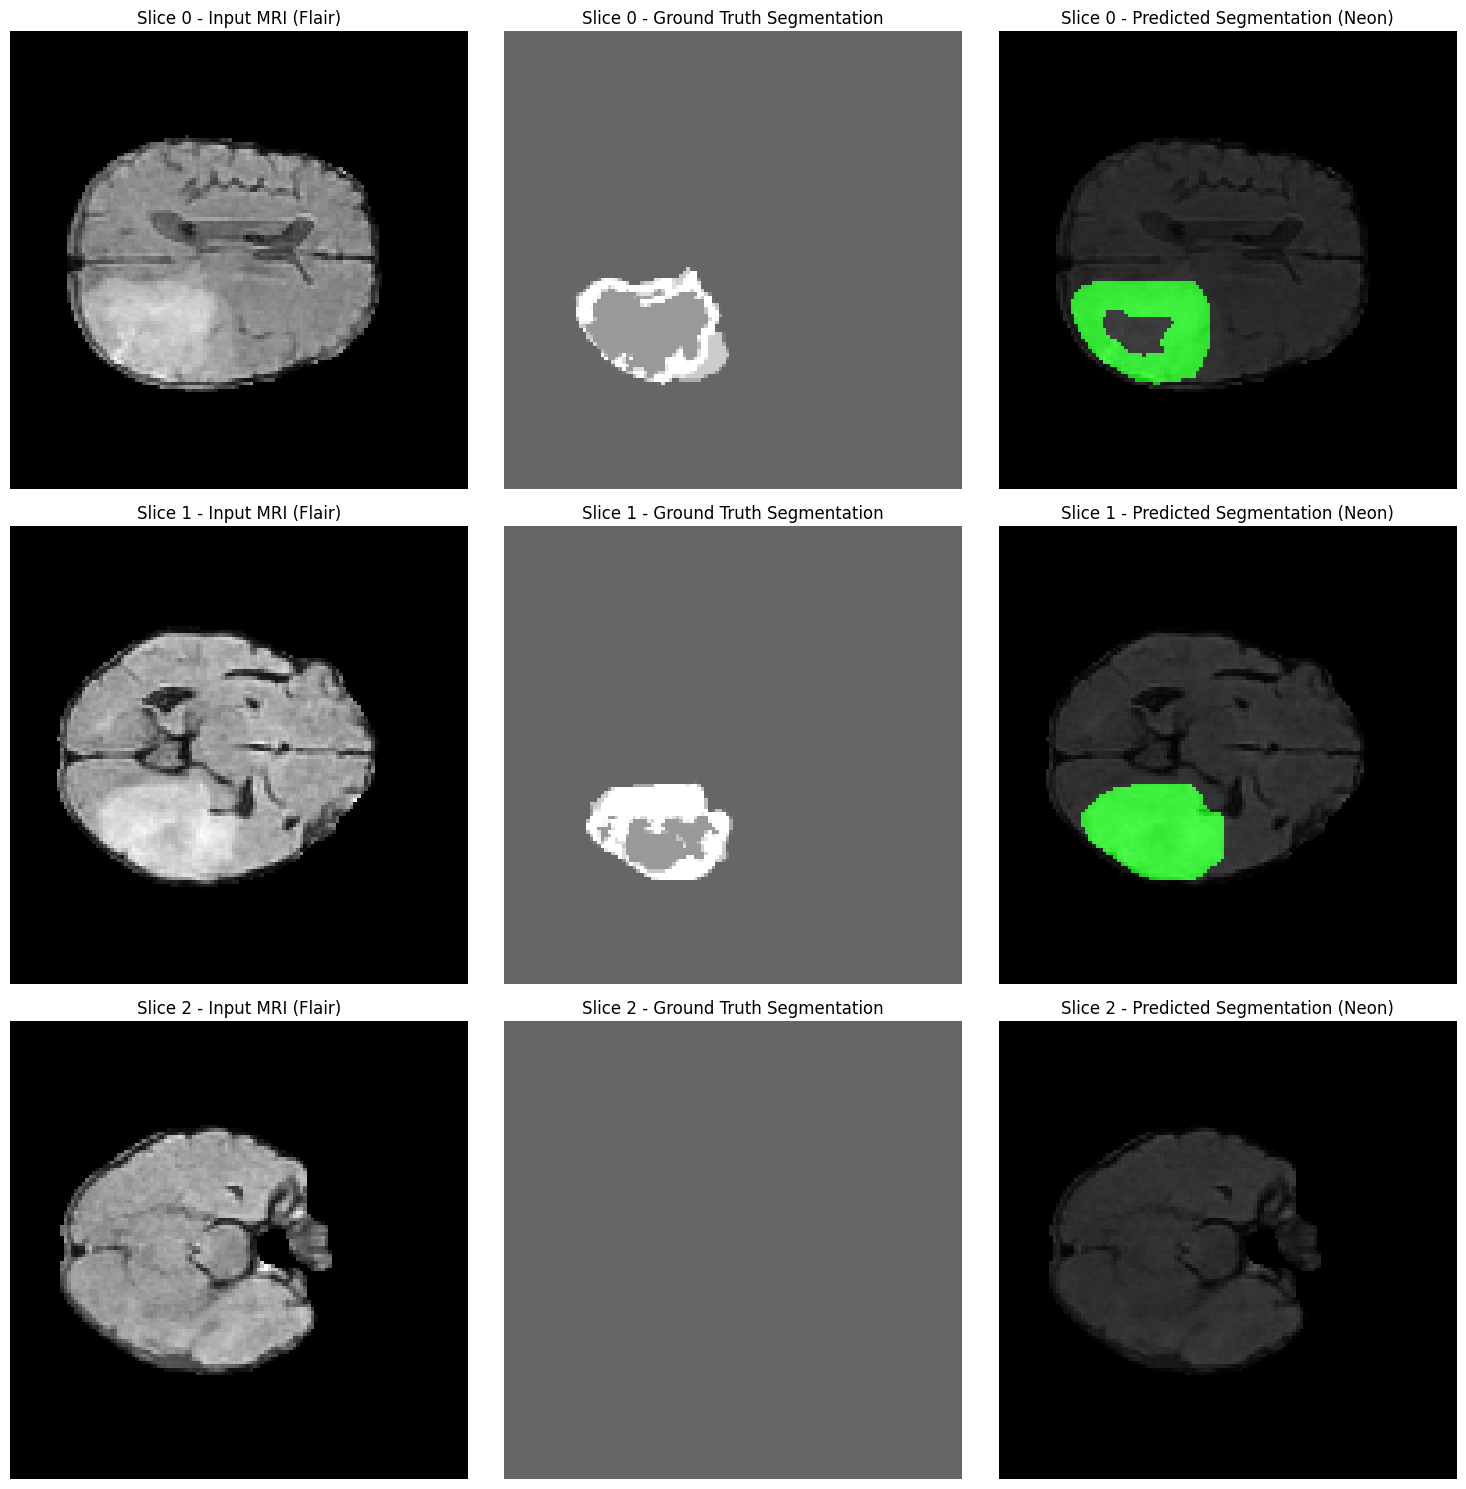

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Custom neon colormap
neon_cmap = LinearSegmentedColormap.from_list("neon", ["black", "cyan", "magenta", "yellow", "lime"], N=256)

def display_predictions_neon(input_mri, ground_truth, predicted_mask, slice_indices=None):
    """
    Display predictions for multiple slices with neon highlighting.
    
    Parameters:
    - input_mri: Input MRI data (4D array with shape [slices, height, width, channels]).
    - ground_truth: Ground truth segmentation masks (4D array).
    - predicted_mask: Predicted segmentation masks (4D array).
    - slice_indices: List of slice indices to display. If None, it selects a few random slices.
    """
    num_slices = input_mri.shape[0]
    if slice_indices is None:
        slice_indices = np.random.choice(num_slices, size=3, replace=False)  # Select 3 random slices for visualization
    
    fig, axes = plt.subplots(len(slice_indices), 3, figsize=(15, 5 * len(slice_indices)))

    for i, idx in enumerate(slice_indices):
        # Input MRI (Flair channel as an example)
        axes[i, 0].imshow(input_mri[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title(f'Slice {idx} - Input MRI (Flair)')
        axes[i, 0].axis('off')

        # Ground truth segmentation mask
        axes[i, 1].imshow(ground_truth[idx, :, :, 0], cmap='gray', alpha=0.6)
        axes[i, 1].set_title(f'Slice {idx} - Ground Truth Segmentation')
        axes[i, 1].axis('off')

        # Predicted segmentation mask with neon colormap
        axes[i, 2].imshow(input_mri[idx, :, :, 0], cmap='gray')  # Display the input as a background
        axes[i, 2].imshow(predicted_mask[idx, :, :, 0], cmap=neon_cmap, alpha=0.7)  # Neon overlay
        axes[i, 2].set_title(f'Slice {idx} - Predicted Segmentation (Neon)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Make predictions on the validation set (using a few samples for demonstration)
sample_indices = [0, 5, 10]  # Adjust these indices as needed
sample_input = X_val[sample_indices]
sample_ground_truth = Y_val[sample_indices]

# Predict masks for the selected samples
predicted_masks = unet_model.predict(sample_input)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Binarizing the output masks

# Display the predictions with neon highlighting
display_predictions_neon(sample_input, sample_ground_truth, predicted_masks, slice_indices=[0, 1, 2])


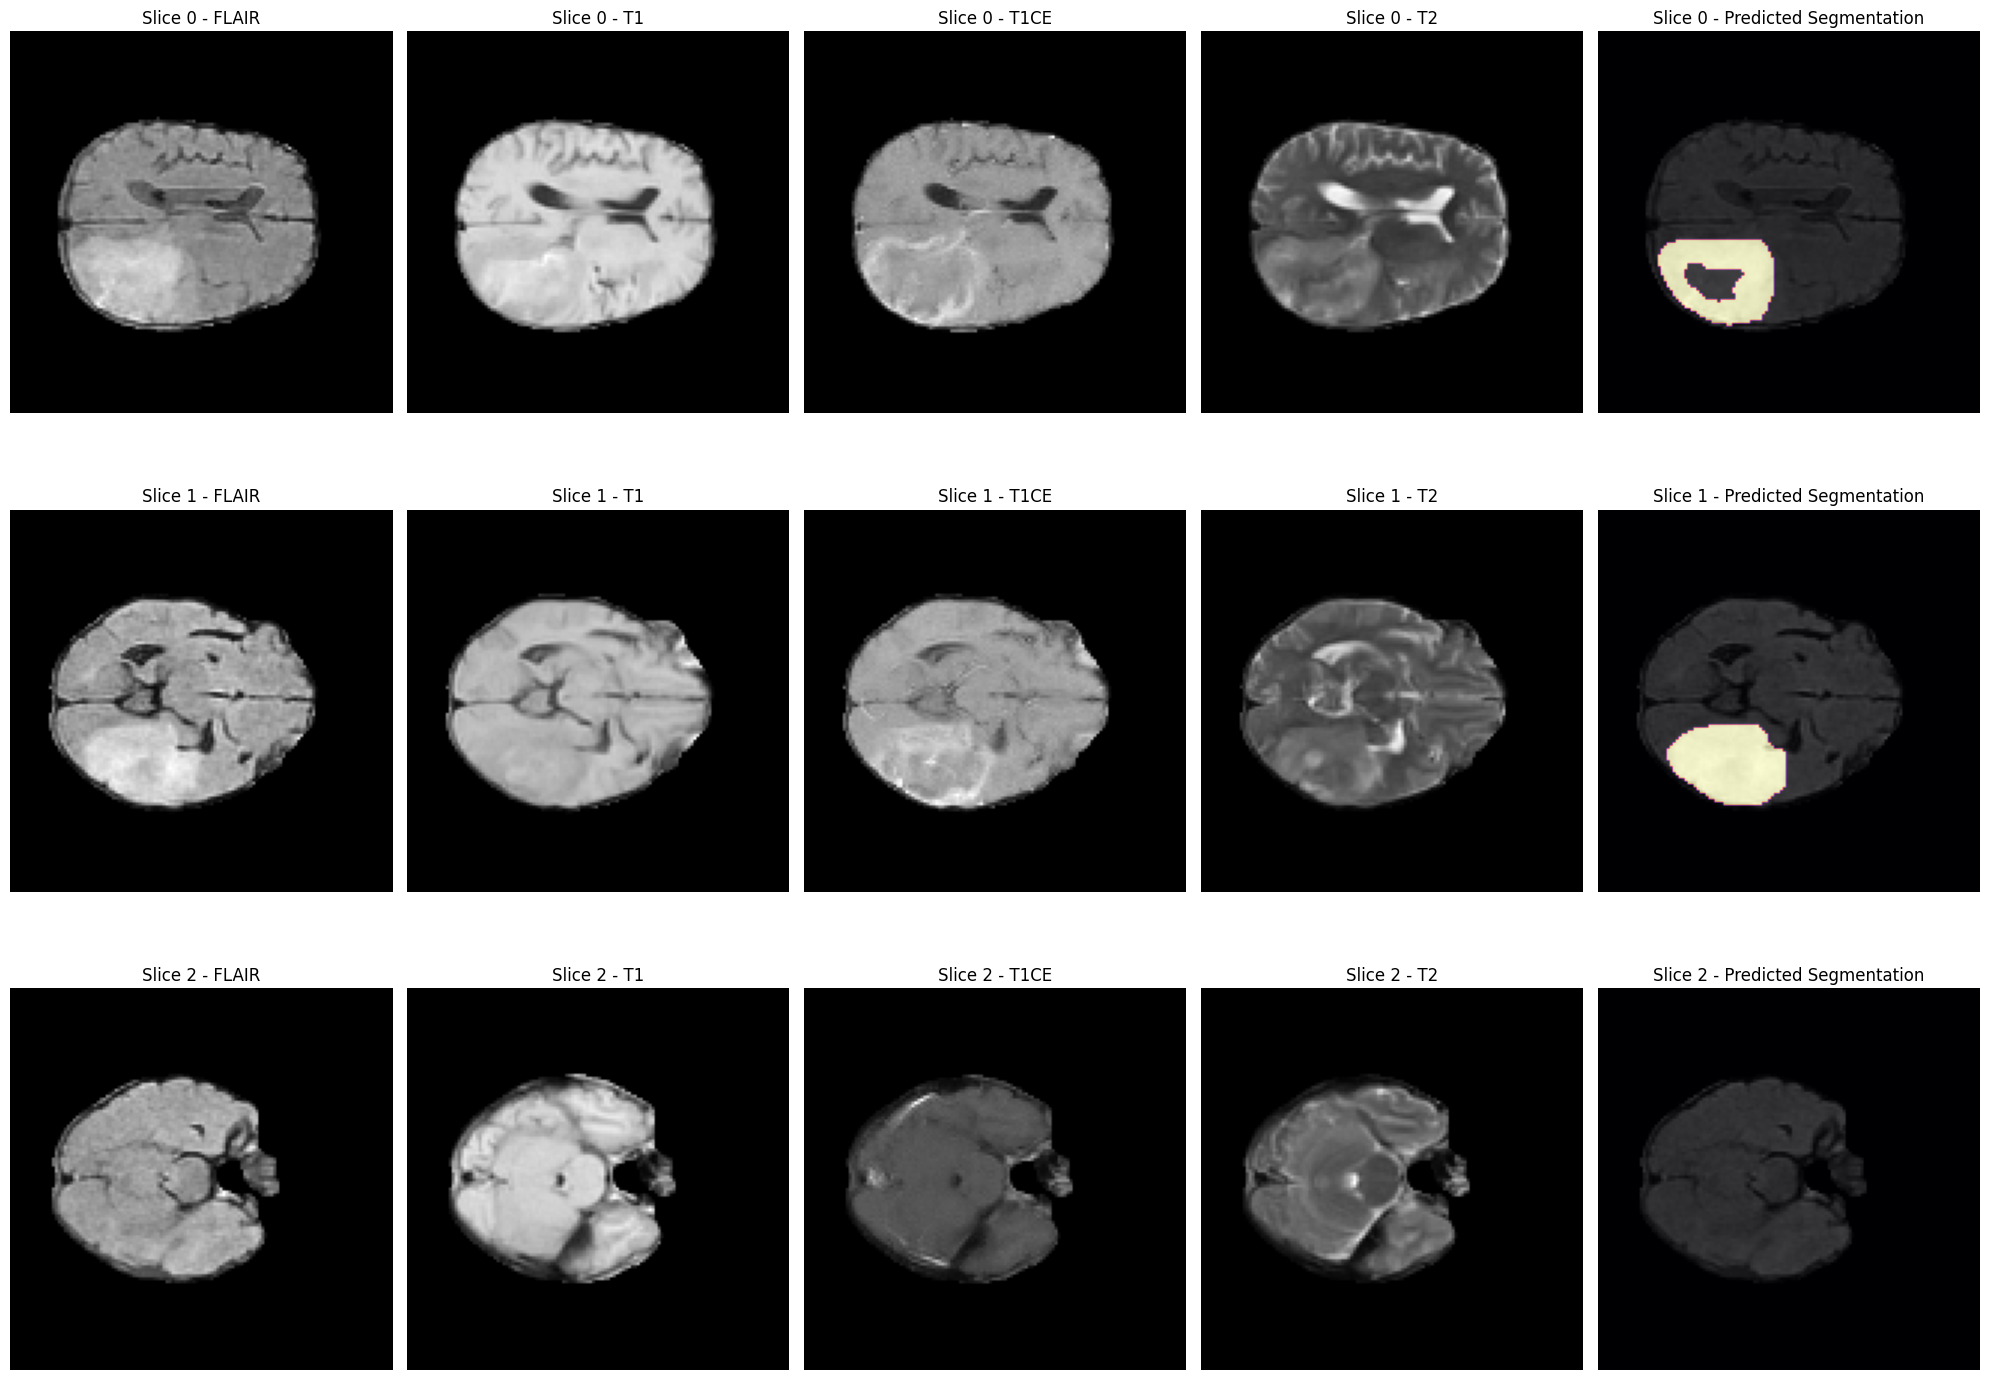

In [13]:
def display_predictions_multi_modal(input_mri, ground_truth, predicted_mask, slice_indices=None):
    """
    Display predictions for multiple slices with comparisons across all modalities.
    
    Parameters:
    - input_mri: Input MRI data (4D array with shape [slices, height, width, channels]).
    - ground_truth: Ground truth segmentation masks (4D array).
    - predicted_mask: Predicted segmentation masks (4D array).
    - slice_indices: List of slice indices to display. If None, it selects a few random slices.
    """
    num_slices = input_mri.shape[0]
    if slice_indices is None:
        slice_indices = np.random.choice(num_slices, size=3, replace=False)  # Select 3 random slices for visualization
    
    fig, axes = plt.subplots(len(slice_indices), 5, figsize=(20, 5 * len(slice_indices)))

    for i, idx in enumerate(slice_indices):
        # FLAIR channel
        axes[i, 0].imshow(input_mri[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title(f'Slice {idx} - FLAIR')
        axes[i, 0].axis('off')

        # T1 channel
        axes[i, 1].imshow(input_mri[idx, :, :, 2], cmap='gray')
        axes[i, 1].set_title(f'Slice {idx} - T1')
        axes[i, 1].axis('off')

        # T1CE channel
        axes[i, 2].imshow(input_mri[idx, :, :, 1], cmap='gray')
        axes[i, 2].set_title(f'Slice {idx} - T1CE')
        axes[i, 2].axis('off')

        # T2 channel
        axes[i, 3].imshow(input_mri[idx, :, :, 3], cmap='gray')
        axes[i, 3].set_title(f'Slice {idx} - T2')
        axes[i, 3].axis('off')

        # Predicted segmentation mask
        axes[i, 4].imshow(input_mri[idx, :, :, 0], cmap='gray')  # Display input as background (e.g., FLAIR)
        axes[i, 4].imshow(predicted_mask[idx, :, :, 0], cmap='magma', alpha=0.7)  # Overlay predicted mask
        axes[i, 4].set_title(f'Slice {idx} - Predicted Segmentation')
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions with all modalities
display_predictions_multi_modal(sample_input, sample_ground_truth, predicted_masks, slice_indices=[0, 1, 2])


Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 0.5682 - accuracy: 0.9732 - val_loss: 0.2785 - val_accuracy: 0.9791
Epoch 2/50
16/16 [==============================] - 18s 1s/step - loss: 0.1854 - accuracy: 0.9779 - val_loss: 0.0818 - val_accuracy: 0.9791
Epoch 3/50
16/16 [==============================] - 18s 1s/step - loss: 0.0580 - accuracy: 0.9779 - val_loss: 0.0306 - val_accuracy: 0.9791
Epoch 4/50
16/16 [==============================] - 18s 1s/step - loss: 0.0292 - accuracy: 0.9779 - val_loss: 0.0240 - val_accuracy: 0.9791
Epoch 5/50
16/16 [==============================] - 18s 1s/step - loss: 0.0242 - accuracy: 0.9779 - val_loss: 0.0218 - val_accuracy: 0.9791
Epoch 6/50
16/16 [==============================] - 18s 1s/step - loss: 0.0231 - accuracy: 0.9779 - val_loss: 0.0203 - val_accuracy: 0.9791
Epoch 7/50
16/16 [==============================] - 19s 1s/step - loss: 0.0219 - accuracy: 0.9779 - val_loss: 0.0213 - val_accuracy: 0.9791
Epoch 8/50
16/16 [==

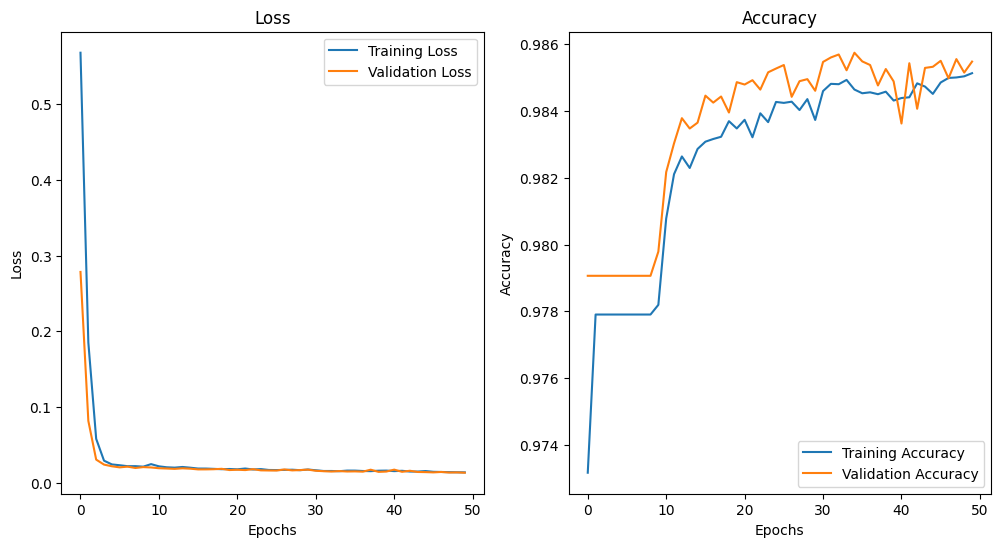

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, Multiply, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define an attention block
def attention_block(x, g, inter_channel):
    """
    Basic attention block for feature refinement.
    """
    theta_x = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(g)
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, kernel_size=1, strides=1, padding='same')(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = Multiply()([x, rate])
    return att_x

# Build an attention-enhanced U-Net model
def build_attention_unet(input_shape=(128, 128, 4)):
    inputs = Input(input_shape)
    
    # Downsampling
    c1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(p4)
    c5 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(c5)
    c5 = Dropout(0.5)(c5)
    
    # Upsampling with attention
    u6 = UpSampling2D(size=(2, 2))(c5)
    att4 = attention_block(c4, u6, inter_channel=256)
    u6 = concatenate([u6, att4], axis=-1)
    c6 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(u6)
    c6 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D(size=(2, 2))(c6)
    att3 = attention_block(c3, u7, inter_channel=128)
    u7 = concatenate([u7, att3], axis=-1)
    c7 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(u7)
    c7 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D(size=(2, 2))(c7)
    att2 = attention_block(c2, u8, inter_channel=64)
    u8 = concatenate([u8, att2], axis=-1)
    c8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u8)
    c8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D(size=(2, 2))(c8)
    att1 = attention_block(c1, u9, inter_channel=32)
    u9 = concatenate([u9, att1], axis=-1)
    c9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(u9)
    c9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c9)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build and compile the model
attention_unet_model = build_attention_unet()

# Train the model
history = attention_unet_model.fit(X_train, Y_train, 
                                   validation_data=(X_val, Y_val), 
                                   epochs=50, 
                                   batch_size=8, 
                                   verbose=1)

# Save the trained model
attention_unet_model.save("attention_enhanced_unet_model1.h5")

print("Attention-enhanced U-Net model saved as 'attention_enhanced_unet_model1.h5'")

# Evaluate the model
loss, accuracy = attention_unet_model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Optional: Plotting training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



1/1 [==============================] - 0s 432ms/step


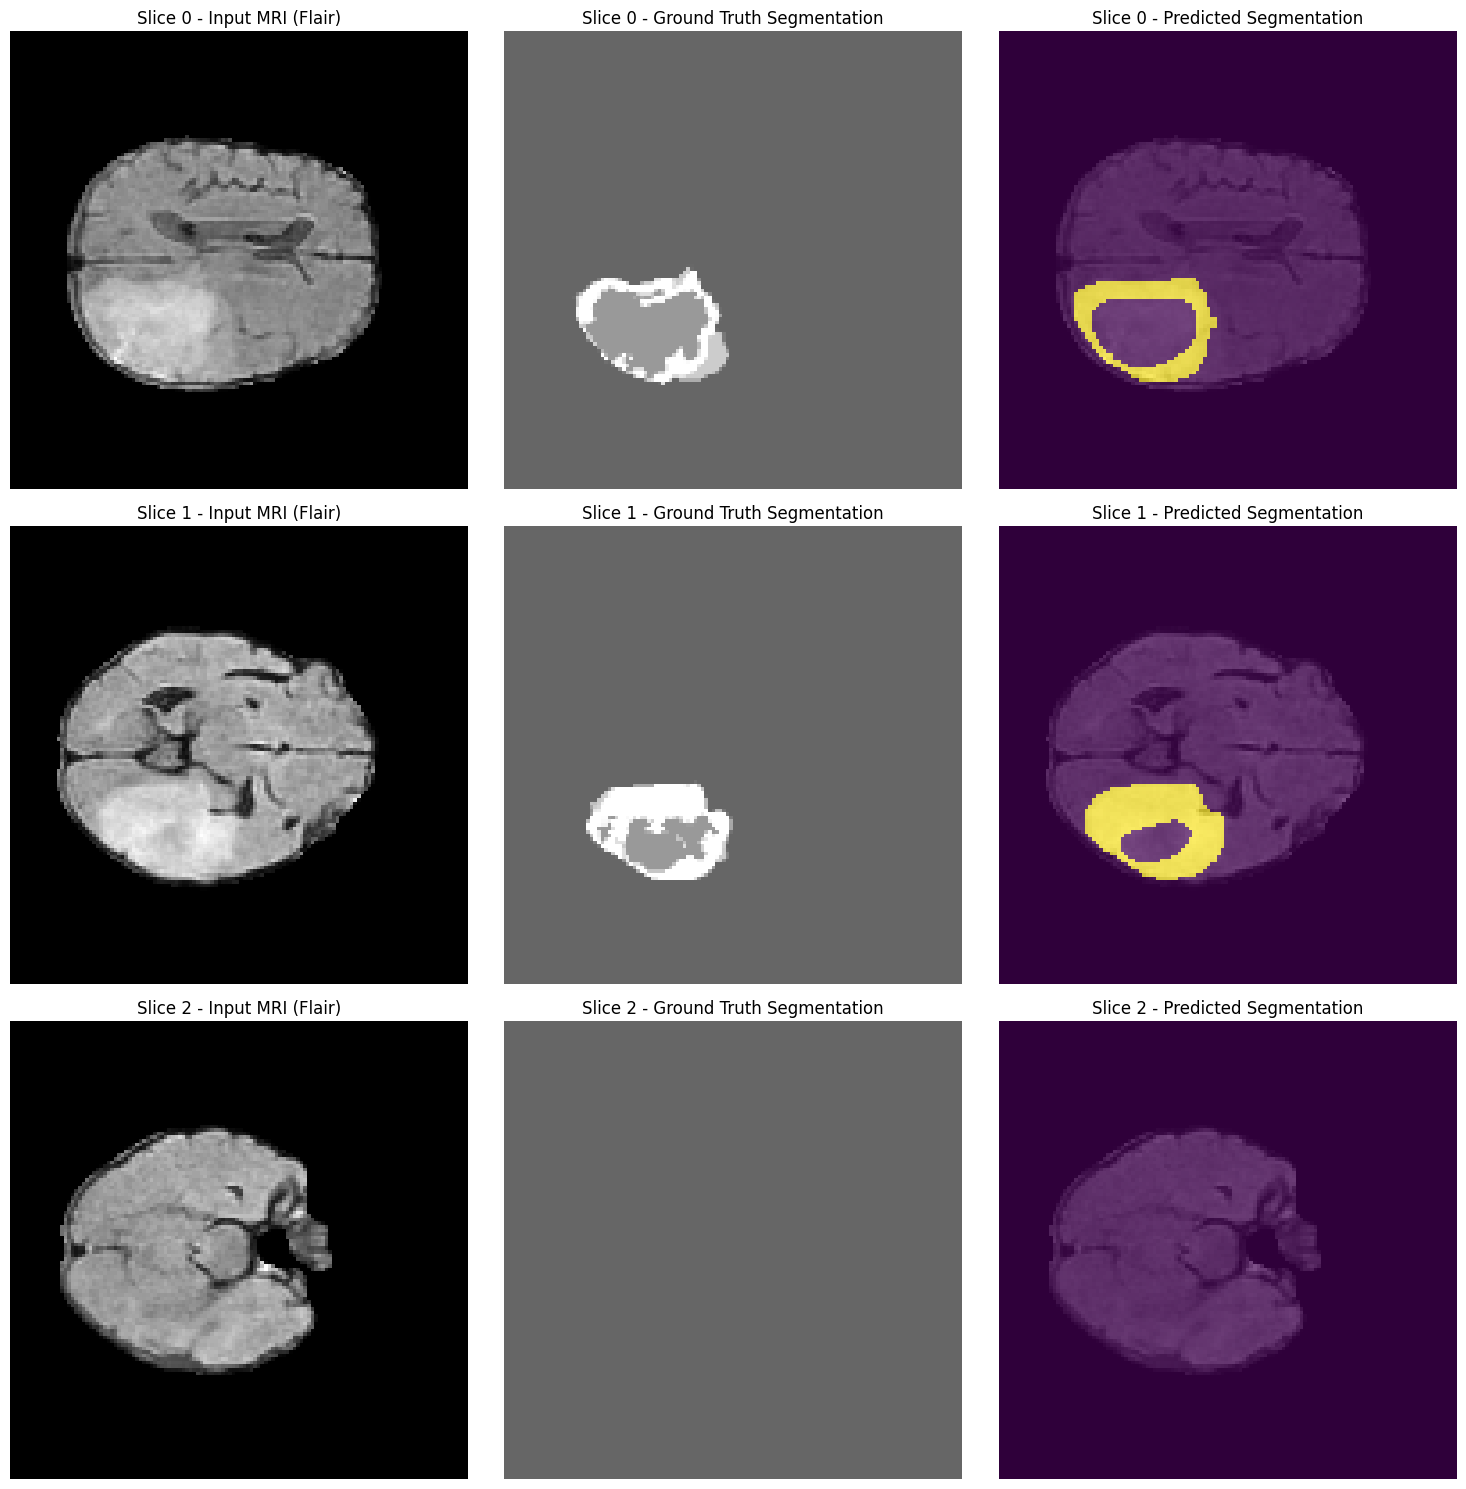

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model if not already loaded
from tensorflow.keras.models import load_model

attention_unet_model = load_model("attention_enhanced_unet_model1.h5", compile=False)

# Make predictions on a sample from the validation set
sample_indices = [0, 5, 10, 15, 20]  # You can change these indices based on your data
sample_input = X_val[sample_indices]
sample_ground_truth = Y_val[sample_indices]

# Predict masks for the selected samples
predicted_masks = attention_unet_model.predict(sample_input)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Binarize the predictions

# Display the predictions
def display_predictions(input_mri, ground_truth, predicted_mask, slice_indices=None):
    """
    Display predictions for multiple slices with enhanced visualization.
    
    Parameters:
    - input_mri: Input MRI data (4D array with shape [slices, height, width, channels]).
    - ground_truth: Ground truth segmentation masks (4D array).
    - predicted_mask: Predicted segmentation masks (4D array).
    - slice_indices: List of slice indices to display. If None, it selects a few random slices.
    """
    num_slices = input_mri.shape[0]
    if slice_indices is None:
        slice_indices = np.random.choice(num_slices, size=5, replace=False)  # Select 3 random slices for visualization
    
    fig, axes = plt.subplots(len(slice_indices), 3, figsize=(15, 5 * len(slice_indices)))

    for i, idx in enumerate(slice_indices):
        # Input MRI (Flair channel as an example)
        axes[i, 0].imshow(input_mri[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title(f'Slice {idx} - Input MRI (Flair)')
        axes[i, 0].axis('off')

        # Ground truth segmentation mask
        axes[i, 1].imshow(ground_truth[idx, :, :, 0], cmap='gray', alpha=0.6)
        axes[i, 1].set_title(f'Slice {idx} - Ground Truth Segmentation')
        axes[i, 1].axis('off')

        # Predicted segmentation mask
        axes[i, 2].imshow(input_mri[idx, :, :, 0], cmap='gray')  # Display the input as a background
        axes[i, 2].imshow(predicted_mask[idx, :, :, 0], cmap='viridis', alpha=0.7)  # Overlay the predicted mask
        axes[i, 2].set_title(f'Slice {idx} - Predicted Segmentation')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions using the new model
display_predictions(sample_input, sample_ground_truth, predicted_masks, slice_indices=[0, 1, 2])


1/1 [==============================] - 0s 316ms/step


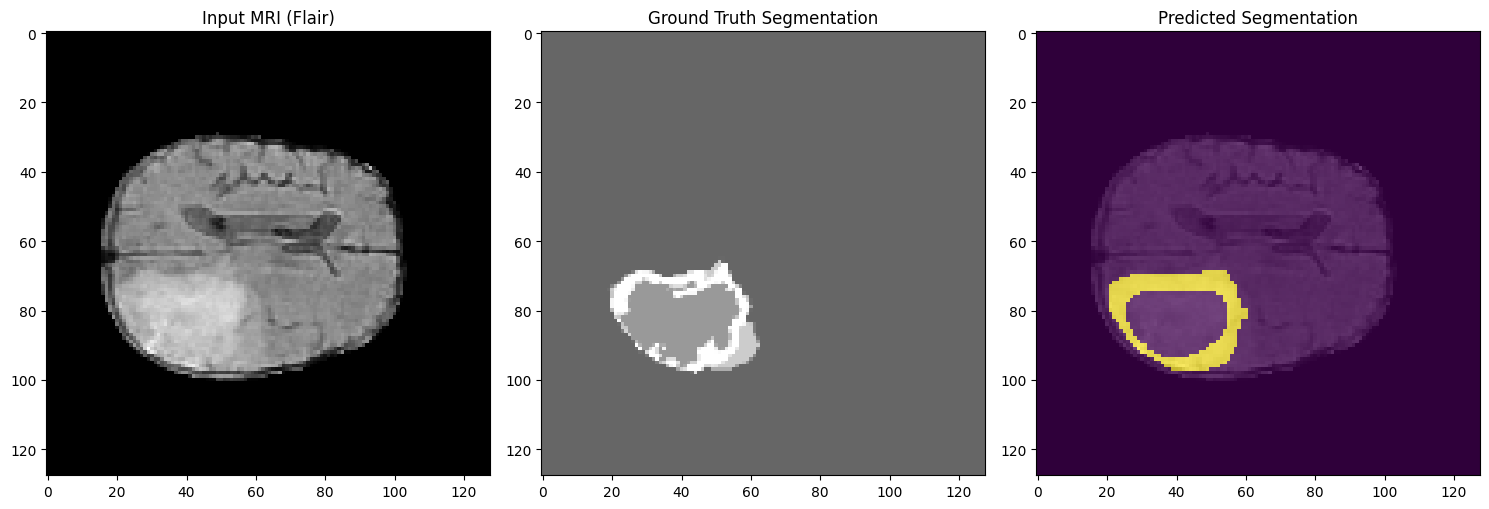

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from matplotlib.animation import FuncAnimation

# Load the trained model if not already loaded
attention_unet_model = load_model("attention_enhanced_unet_model1.h5", compile=False)

# Example indices for additional test cases; you can modify these as needed
sample_index = 0  # Select one index from the test data for traversal (you can change this)
input_mri = X_val[sample_index]  # Select a single test sample (Assuming shape is [height, width, slices, channels])
ground_truth = Y_val[sample_index]  # Ground truth for the sample (Assuming shape is [height, width, slices])

# Ensure input_mri is a 3D array (height, width, slices)
if input_mri.ndim == 4:
    input_mri = input_mri[..., 0]  # Assuming we only care about the first channel

# Predict mask for the selected test sample
predicted_mask = attention_unet_model.predict(np.expand_dims(input_mri, axis=(0, -1)))[0]
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Binarize the prediction

# Set up the figure and axis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Initialize the plot with the first slice
slice_idx = 0
img_input = axes[0].imshow(input_mri[:, :, slice_idx], cmap='gray')
img_ground_truth = axes[1].imshow(ground_truth[:, :, slice_idx], cmap='gray', alpha=0.6)
img_pred = axes[2].imshow(input_mri[:, :, slice_idx], cmap='gray')
img_pred_overlay = axes[2].imshow(predicted_mask[:, :, slice_idx], cmap='viridis', alpha=0.7)

# Titles for each subplot
axes[0].set_title("Input MRI (Flair)")
axes[1].set_title("Ground Truth Segmentation")
axes[2].set_title("Predicted Segmentation")

# Function to update each frame in the animation
def update(slice_idx):
    img_input.set_data(input_mri[:, :, slice_idx])
    img_ground_truth.set_data(ground_truth[:, :, slice_idx])
    img_pred.set_data(input_mri[:, :, slice_idx])  # Background MRI
    img_pred_overlay.set_data(predicted_mask[:, :, slice_idx])  # Predicted overlay
    fig.suptitle(f'Slice {slice_idx}')  # Display slice number

# Create animation
num_slices = input_mri.shape[2]
ani = FuncAnimation(fig, update, frames=num_slices, interval=200)

# Display the animation
plt.tight_layout()
plt.show()


In [26]:
ani.save('mri_segmentation_animation.gif', writer='imagemagick')


MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: index 1 is out of bounds for axis 2 with size 1

IndexError: index 5 is out of bounds for axis 0 with size 5

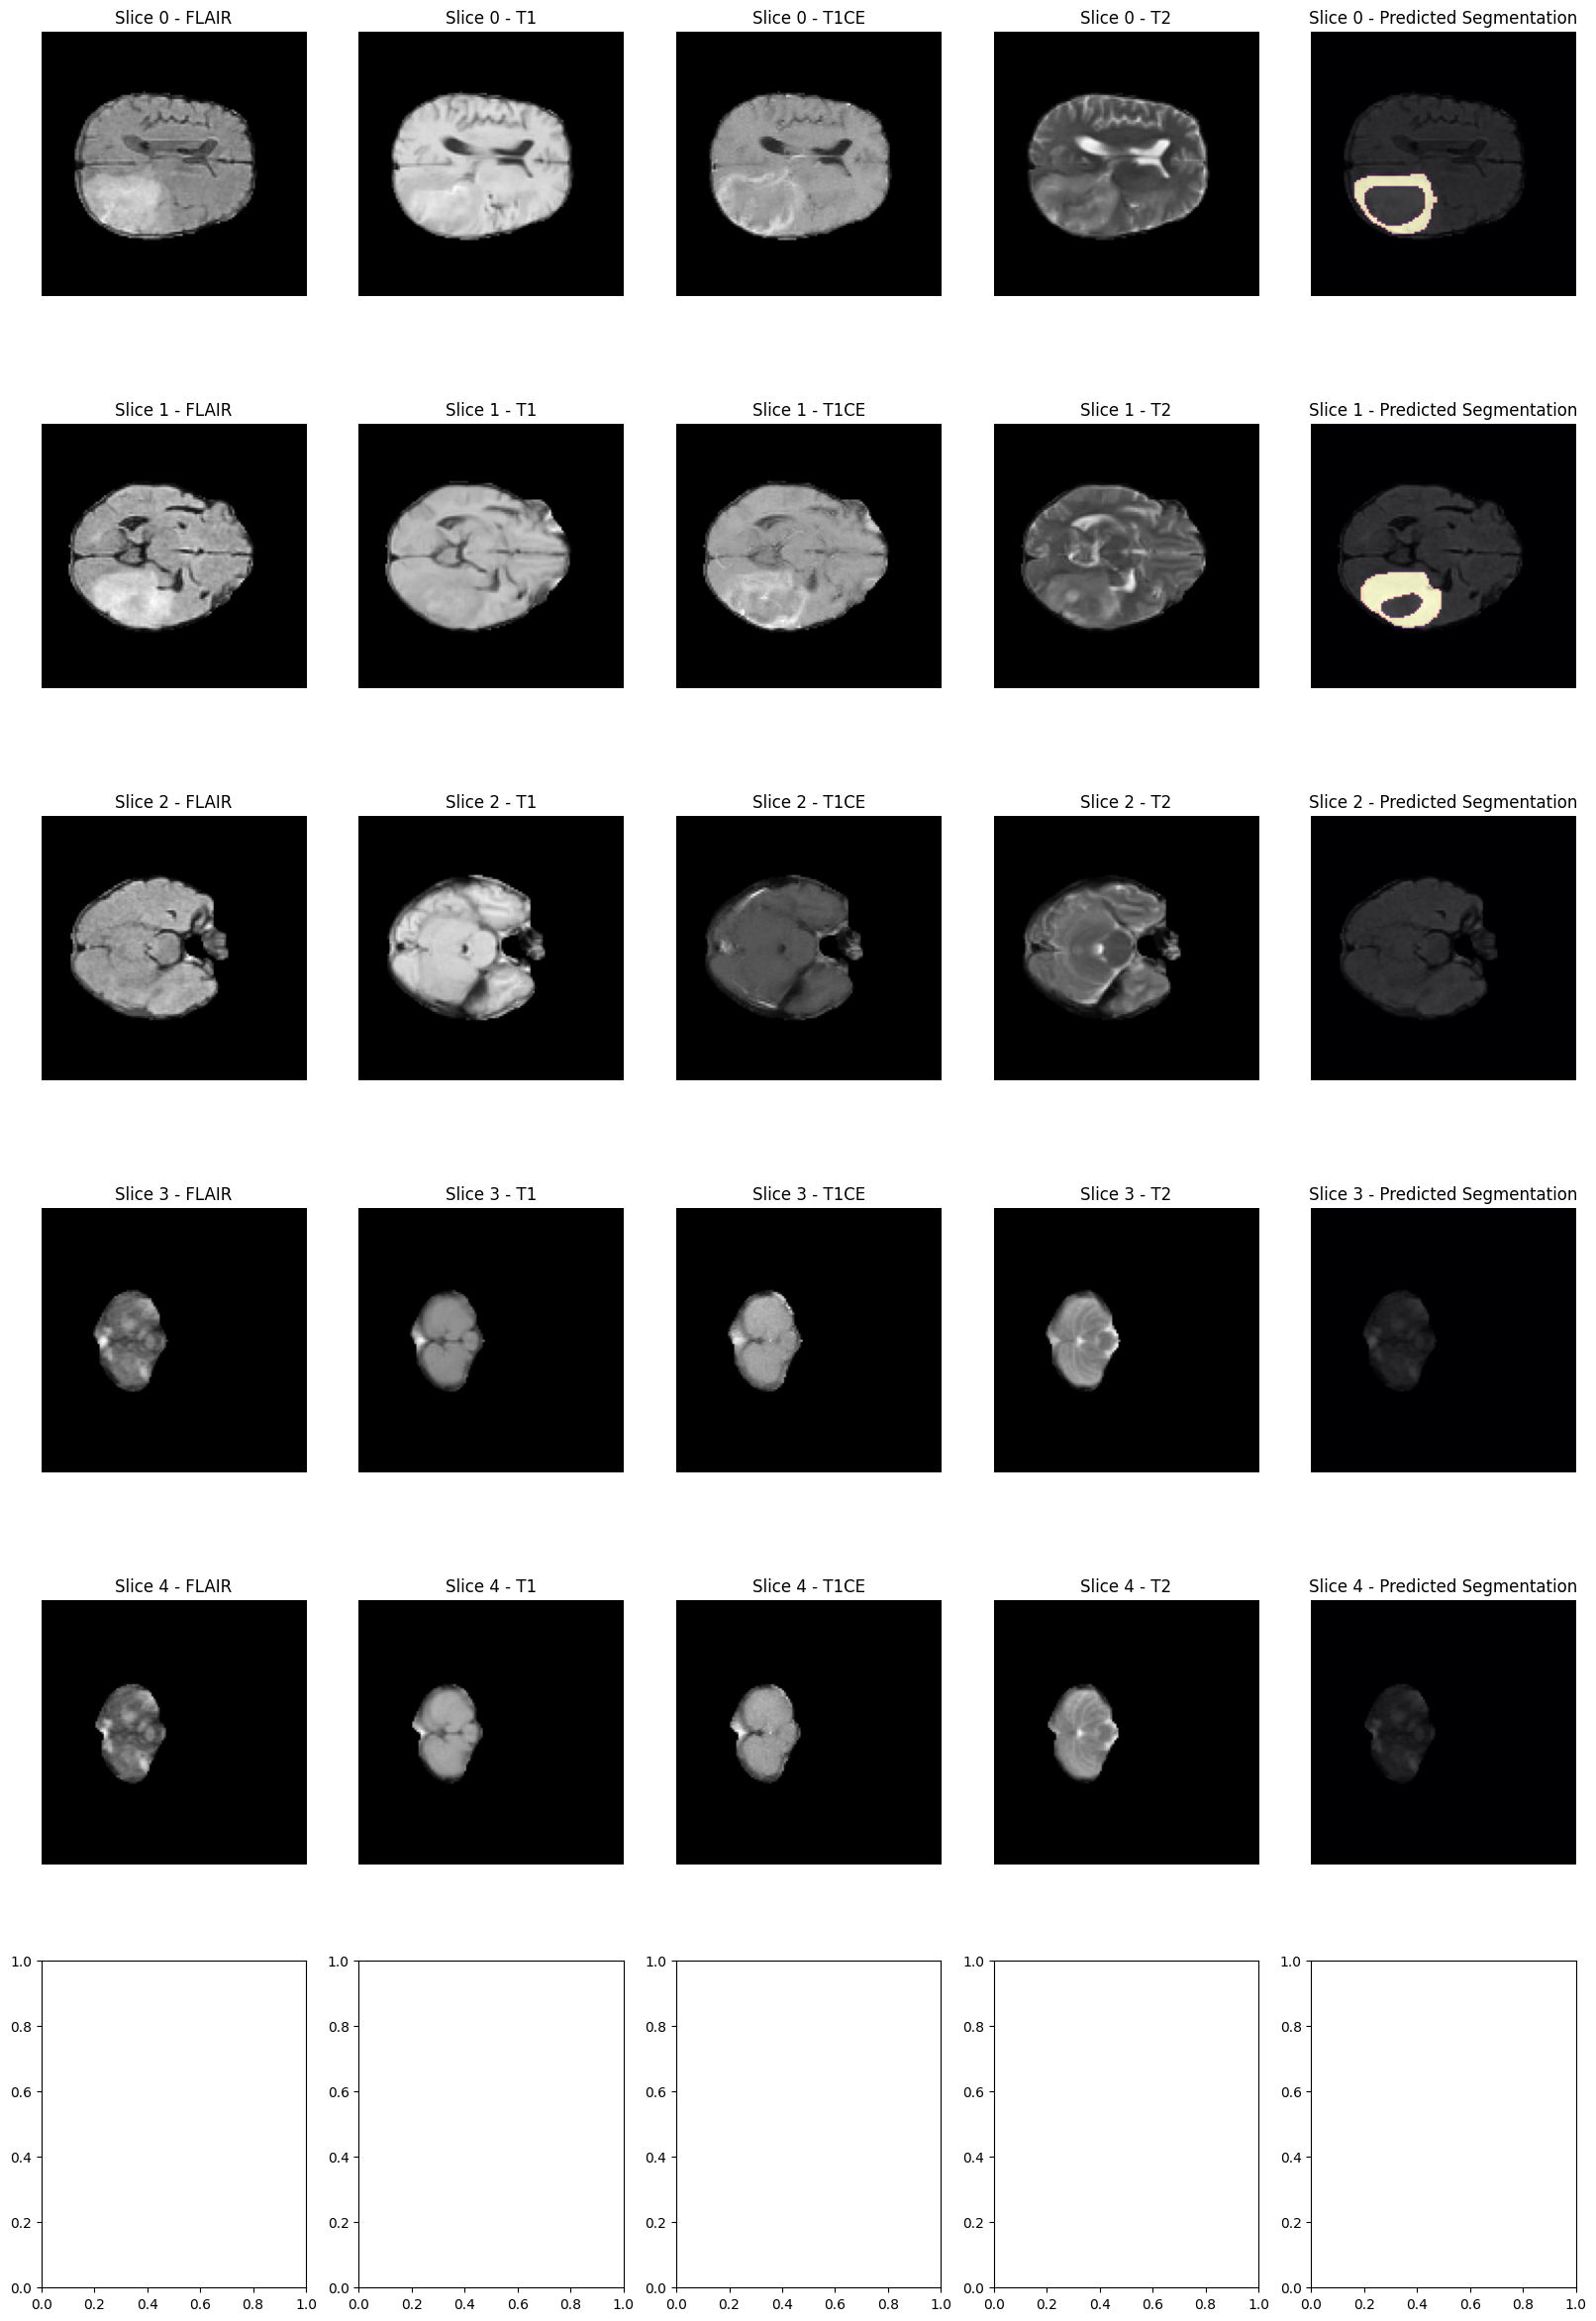

In [27]:
def display_predictions_multi_modal(input_mri, ground_truth, predicted_mask, slice_indices=None):
    """
    Display predictions for multiple slices with comparisons across all modalities.
    
    Parameters:
    - input_mri: Input MRI data (4D array with shape [slices, height, width, channels]).
    - ground_truth: Ground truth segmentation masks (4D array).
    - predicted_mask: Predicted segmentation masks (4D array).
    - slice_indices: List of slice indices to display. If None, it selects a few random slices.
    """
    num_slices = input_mri.shape[0]
    if slice_indices is None:
        slice_indices = np.random.choice(num_slices, size=6, replace=False)  # Select 6 random slices for visualization
    
    fig, axes = plt.subplots(len(slice_indices), 5, figsize=(20, 5 * len(slice_indices)))

    for i, idx in enumerate(slice_indices):
        # FLAIR channel
        axes[i, 0].imshow(input_mri[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title(f'Slice {idx} - FLAIR')
        axes[i, 0].axis('off')

        # T1 channel
        axes[i, 1].imshow(input_mri[idx, :, :, 2], cmap='gray')
        axes[i, 1].set_title(f'Slice {idx} - T1')
        axes[i, 1].axis('off')

        # T1CE channel
        axes[i, 2].imshow(input_mri[idx, :, :, 1], cmap='gray')
        axes[i, 2].set_title(f'Slice {idx} - T1CE')
        axes[i, 2].axis('off')

        # T2 channel
        axes[i, 3].imshow(input_mri[idx, :, :, 3], cmap='gray')
        axes[i, 3].set_title(f'Slice {idx} - T2')
        axes[i, 3].axis('off')

        # Predicted segmentation mask
        axes[i, 4].imshow(input_mri[idx, :, :, 0], cmap='gray')  # Display input as background (e.g., FLAIR)
        axes[i, 4].imshow(predicted_mask[idx, :, :, 0], cmap='magma', alpha=0.7)  # Overlay predicted mask
        axes[i, 4].set_title(f'Slice {idx} - Predicted Segmentation')
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions with all modalities
display_predictions_multi_modal(sample_input, sample_ground_truth, predicted_masks, slice_indices=[0, 1, 2, 3, 4, 5])


1/1 [==============================] - 1s 545ms/step


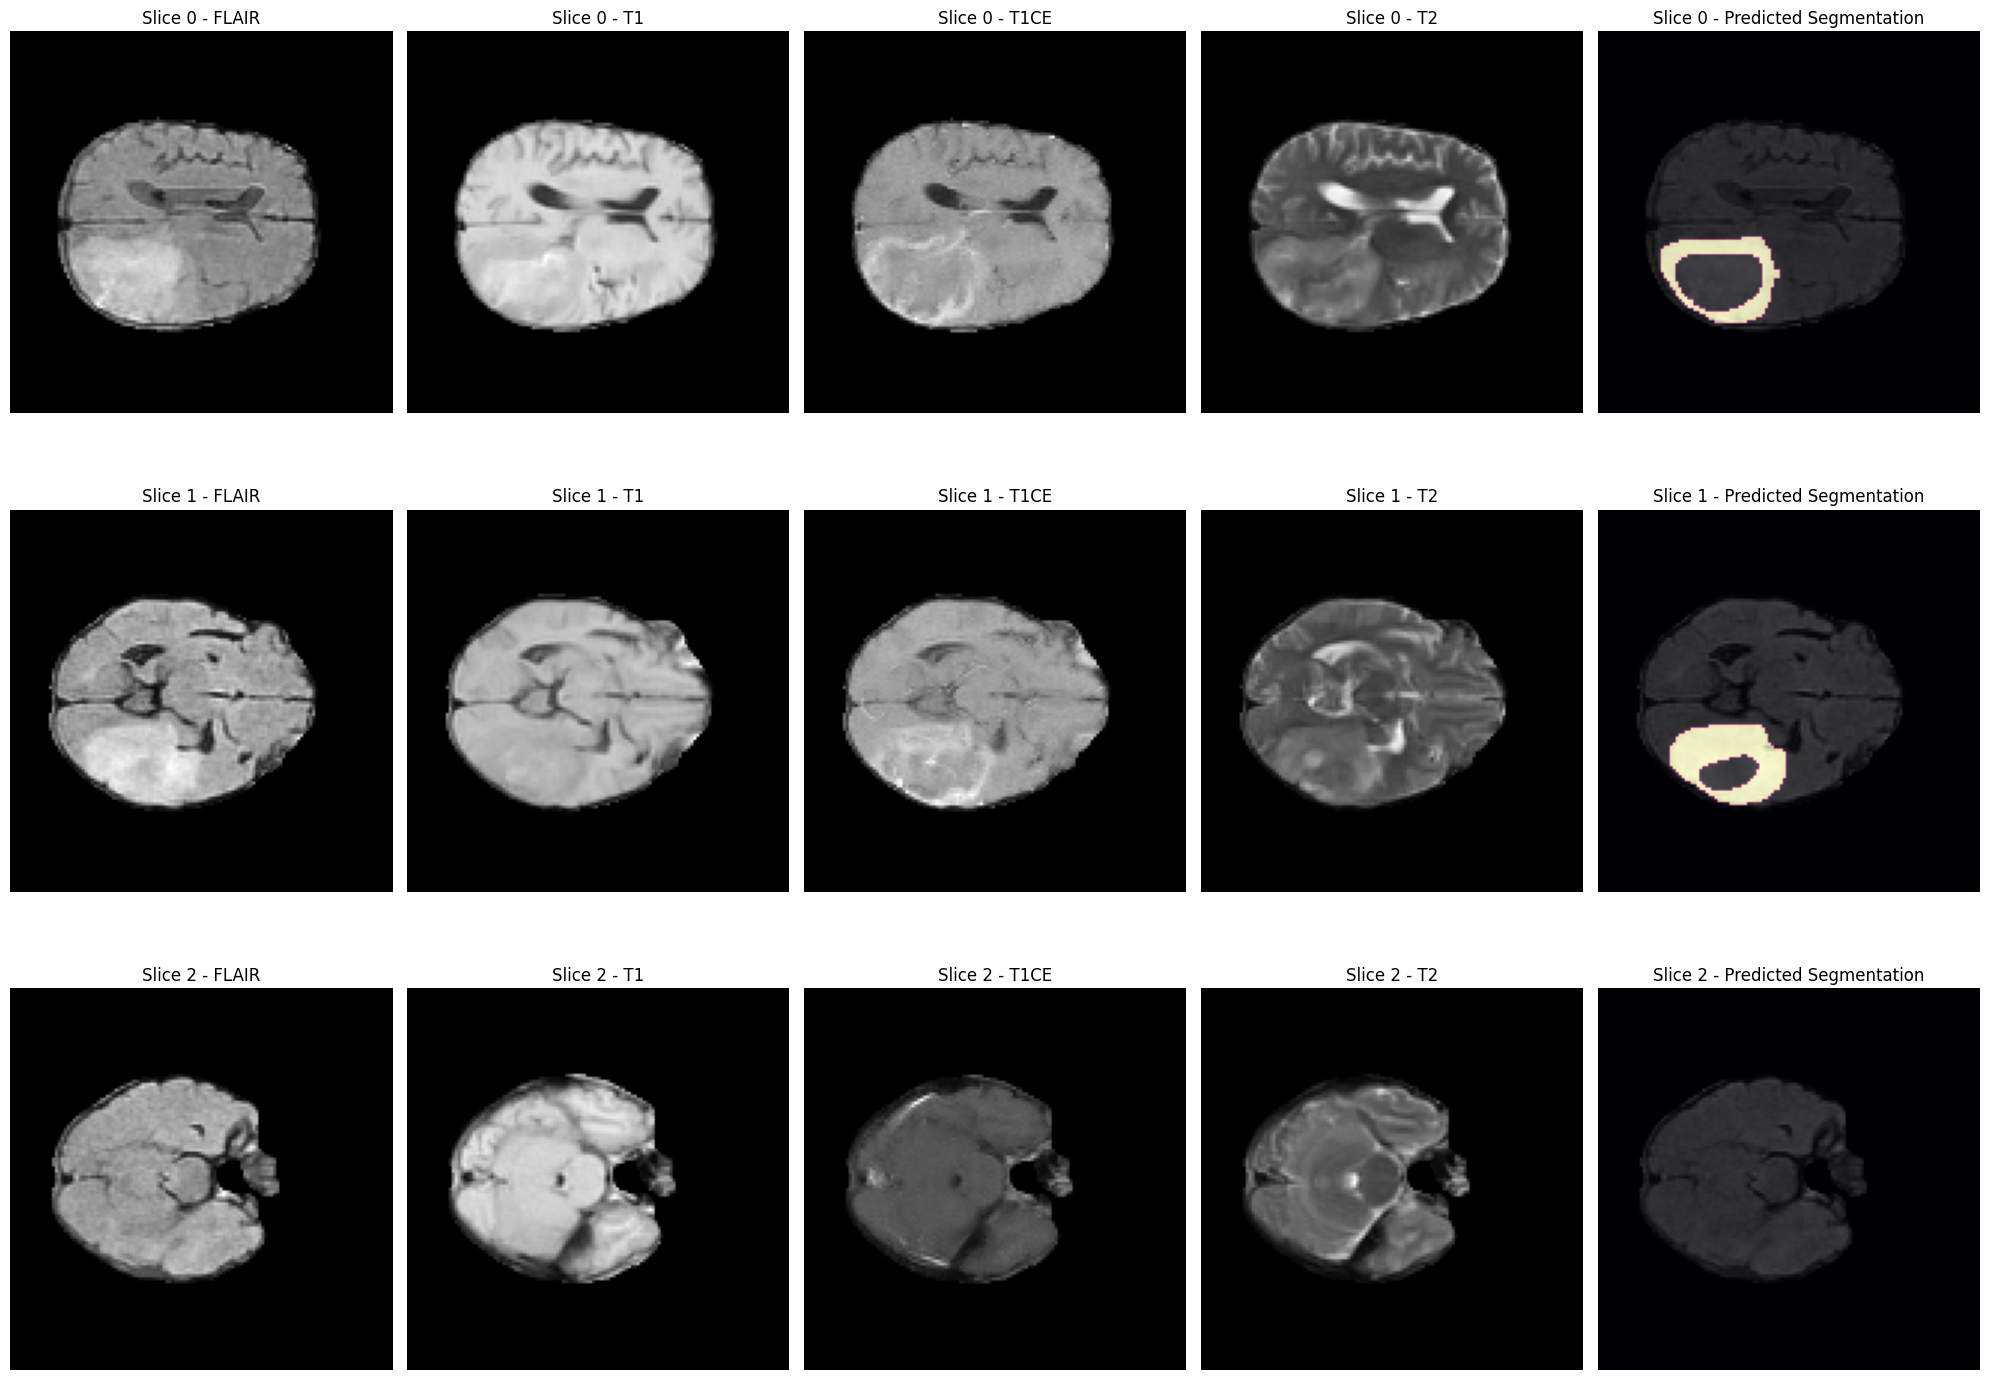

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
attention_unet_model = load_model("attention_enhanced_unet_model1.h5", compile=False)

def filter_valid_slices(input_mri, threshold=50):
    """
    Filter slices that have a minimum number of non-zero pixels.

    Parameters:
    - input_mri: Input MRI data (4D array with shape [slices, height, width, channels]).
    - threshold: Minimum sum of non-zero pixel values to consider a valid slice.

    Returns:
    - List of valid slice indices.
    """
    valid_slices = [i for i in range(input_mri.shape[0]) if np.sum(input_mri[i, :, :, 0]) > threshold]
    return valid_slices

def display_predictions_multi_modal(input_mri, ground_truth, predicted_mask, slice_indices=None):
    """
    Display predictions for multiple slices with comparisons across all modalities.
    
    Parameters:
    - input_mri: Input MRI data (4D array with shape [slices, height, width, channels]).
    - ground_truth: Ground truth segmentation masks (4D array).
    - predicted_mask: Predicted segmentation masks (4D array).
    - slice_indices: List of slice indices to display. If None, it selects a few random slices.
    """
    num_slices = input_mri.shape[0]
    if slice_indices is None:
        valid_slices = filter_valid_slices(input_mri)
        slice_indices = np.random.choice(valid_slices, size=min(6, len(valid_slices)), replace=False)  # Select up to 6 slices
    
    fig, axes = plt.subplots(len(slice_indices), 5, figsize=(20, 5 * len(slice_indices)))

    for i, idx in enumerate(slice_indices):
        # FLAIR channel
        axes[i, 0].imshow(input_mri[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title(f'Slice {idx} - FLAIR')
        axes[i, 0].axis('off')

        # T1 channel
        axes[i, 1].imshow(input_mri[idx, :, :, 2], cmap='gray')
        axes[i, 1].set_title(f'Slice {idx} - T1')
        axes[i, 1].axis('off')

        # T1CE channel
        axes[i, 2].imshow(input_mri[idx, :, :, 1], cmap='gray')
        axes[i, 2].set_title(f'Slice {idx} - T1CE')
        axes[i, 2].axis('off')

        # T2 channel
        axes[i, 3].imshow(input_mri[idx, :, :, 3], cmap='gray')
        axes[i, 3].set_title(f'Slice {idx} - T2')
        axes[i, 3].axis('off')

        # Predicted segmentation mask
        axes[i, 4].imshow(input_mri[idx, :, :, 0], cmap='gray')  # Display input as background (e.g., FLAIR)
        axes[i, 4].imshow(predicted_mask[idx, :, :, 0], cmap='magma', alpha=0.7)  # Overlay predicted mask
        axes[i, 4].set_title(f'Slice {idx} - Predicted Segmentation')
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()

# Generate predictions for a few test cases (assuming you have X_val and Y_val for validation)
sample_indices = [0, 5, 10]  # Change these indices as needed
sample_input = X_val[sample_indices]
sample_ground_truth = Y_val[sample_indices]
predicted_masks = attention_unet_model.predict(sample_input)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Binarize predictions

# Display predictions
display_predictions_multi_modal(sample_input, sample_ground_truth, predicted_masks)


1/1 [==============================] - 1s 1s/step


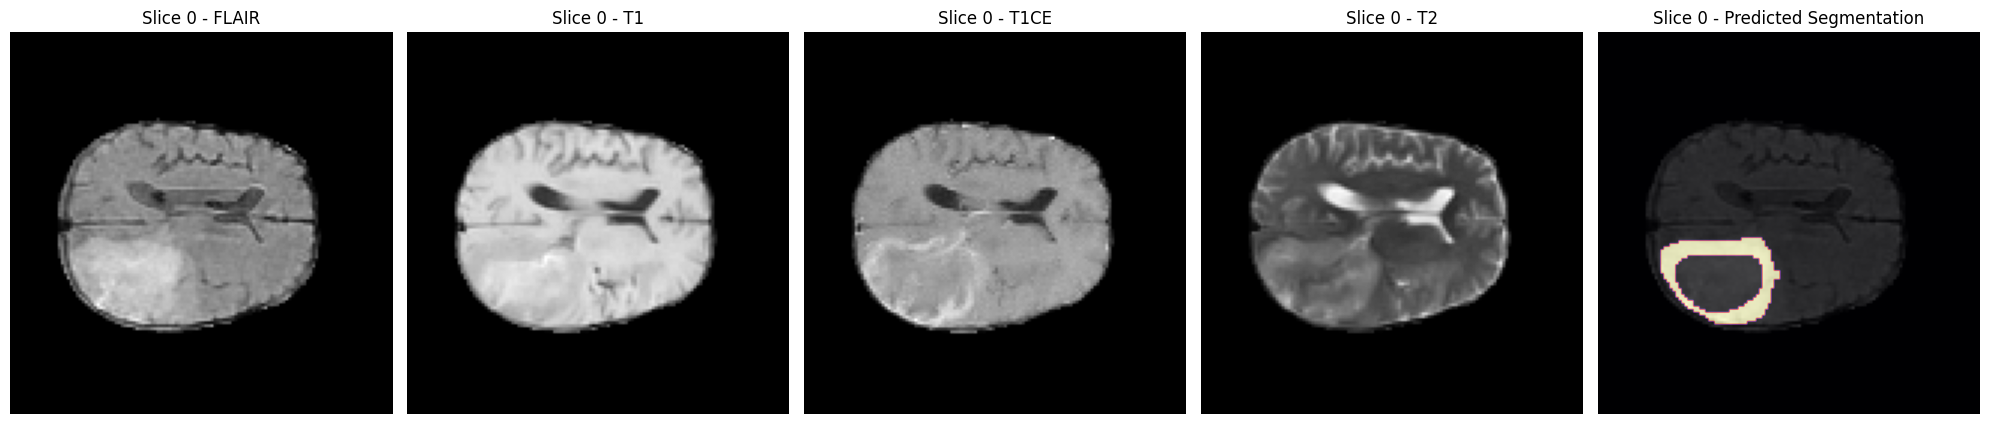

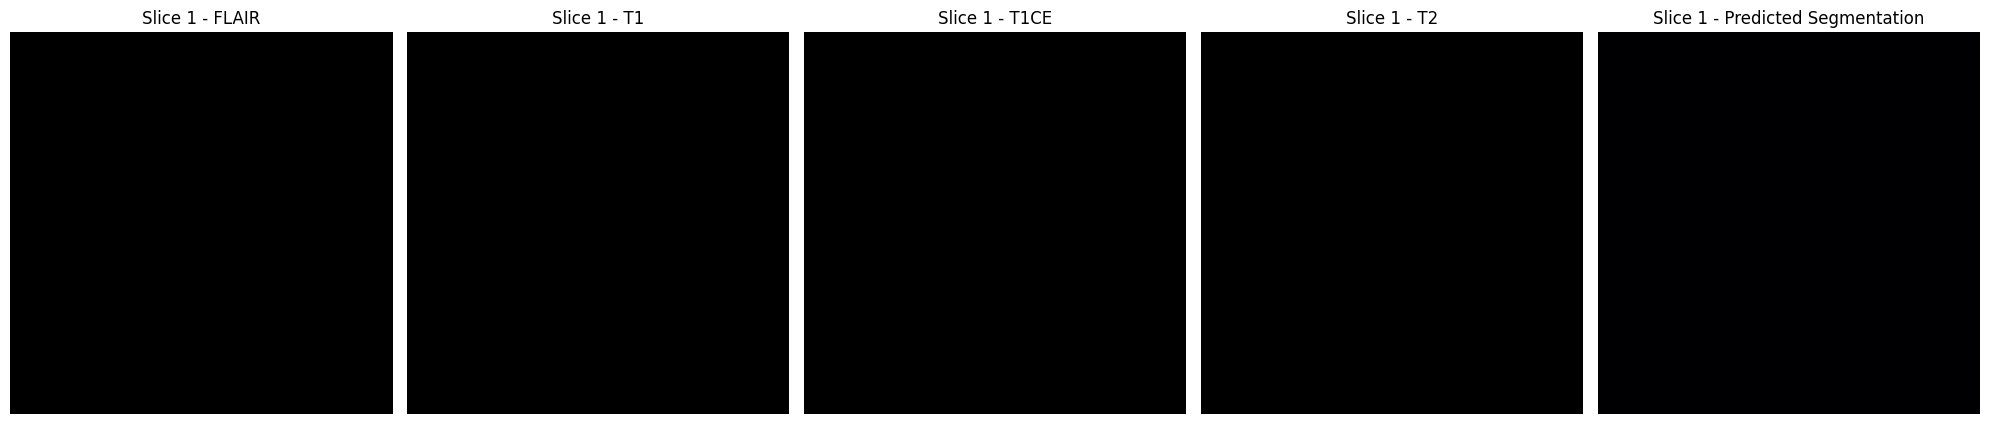

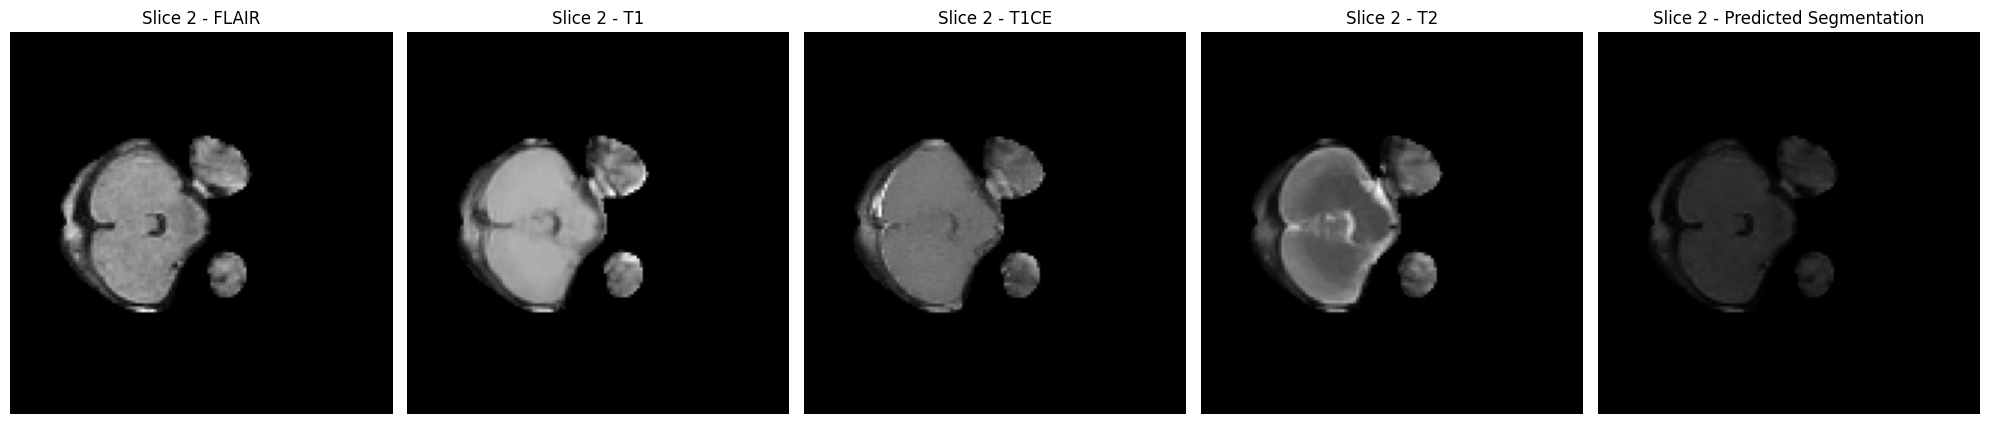

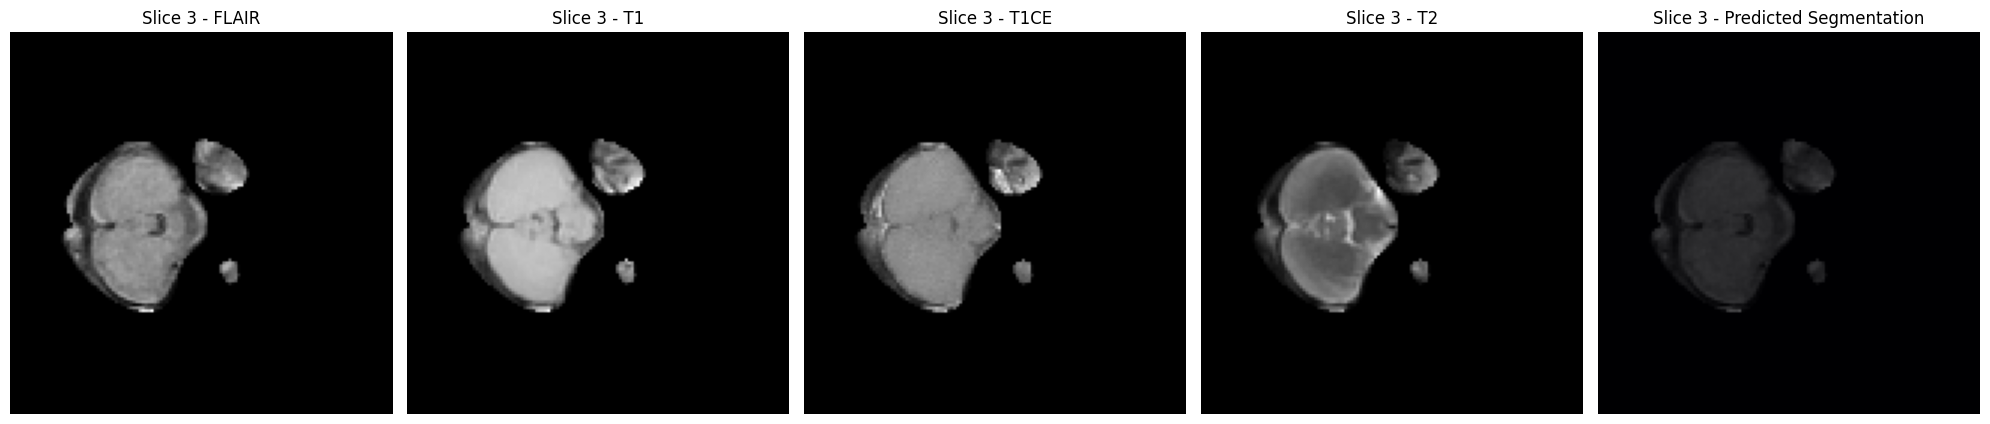

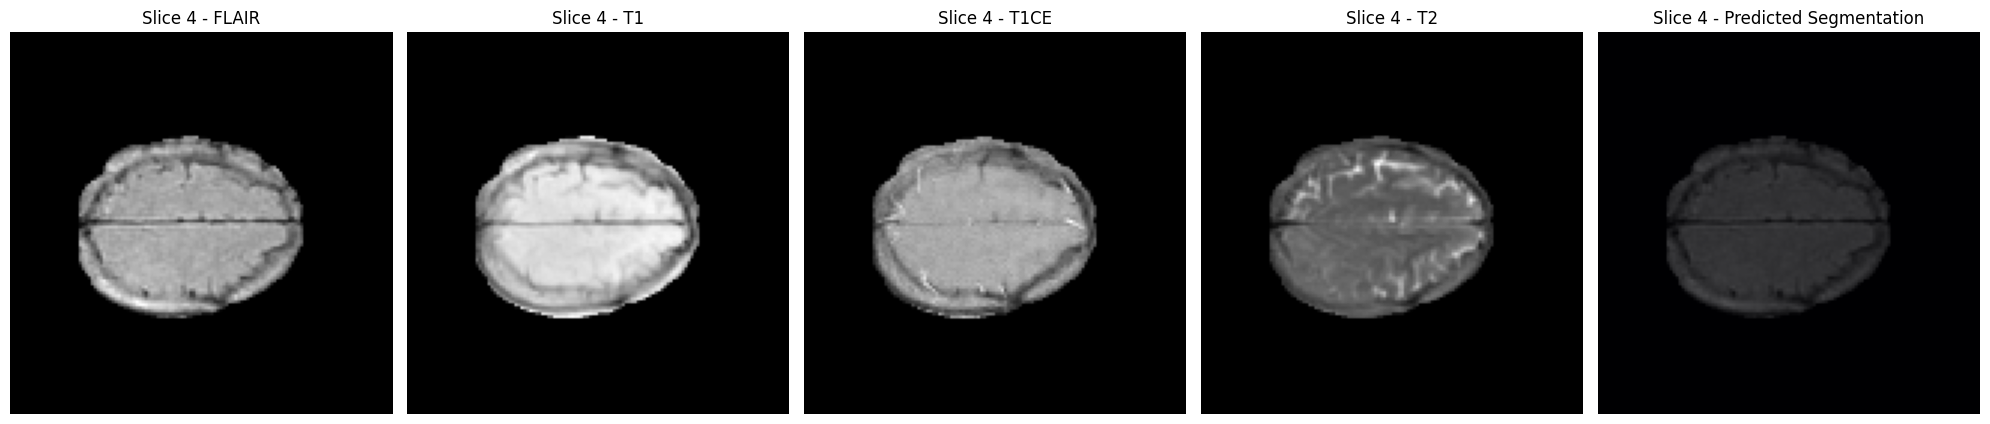

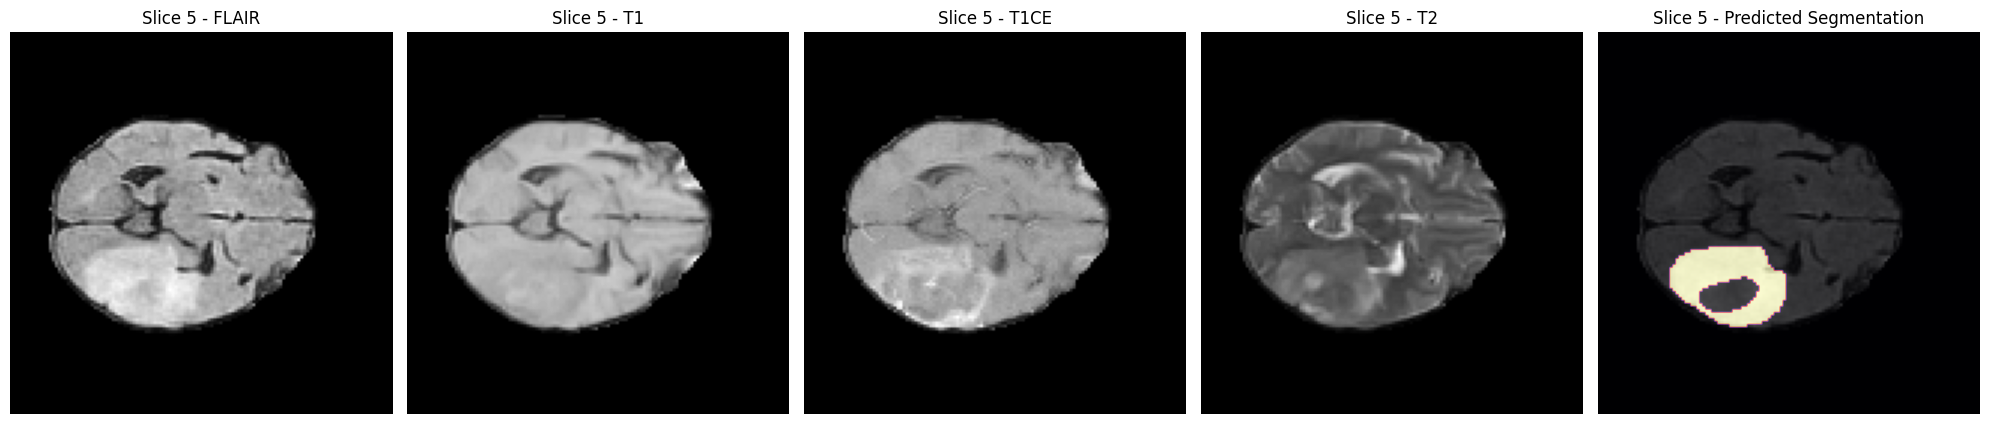

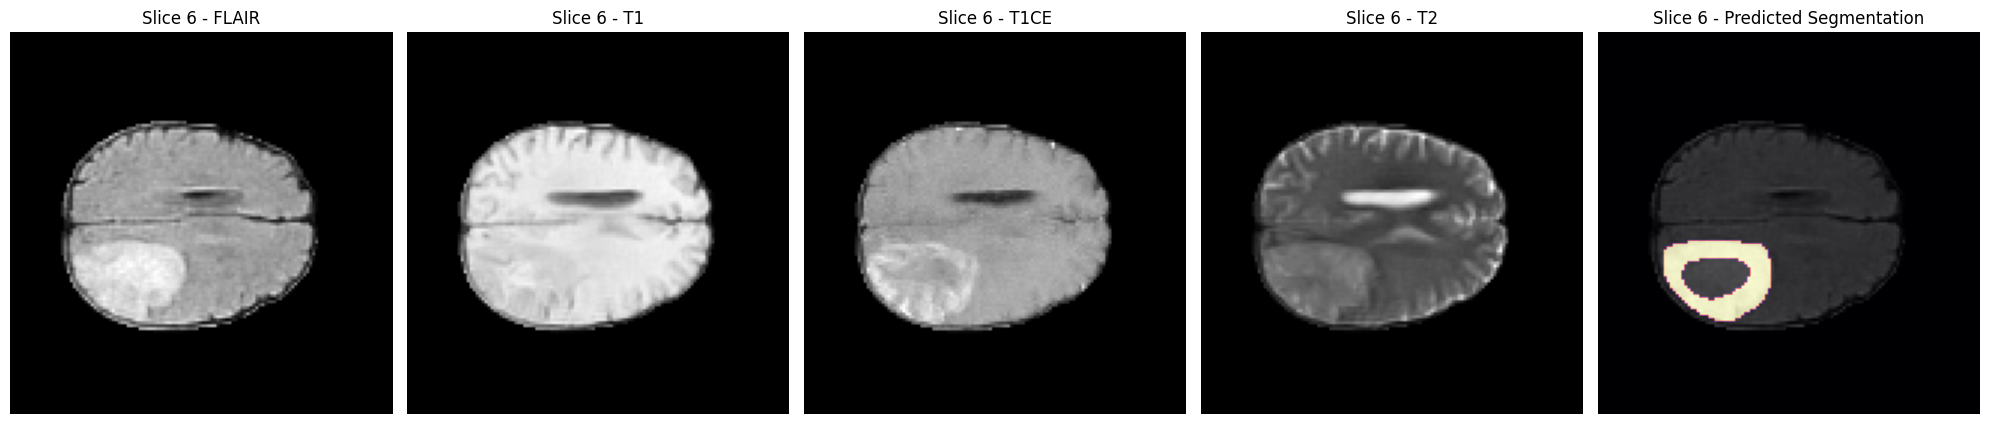

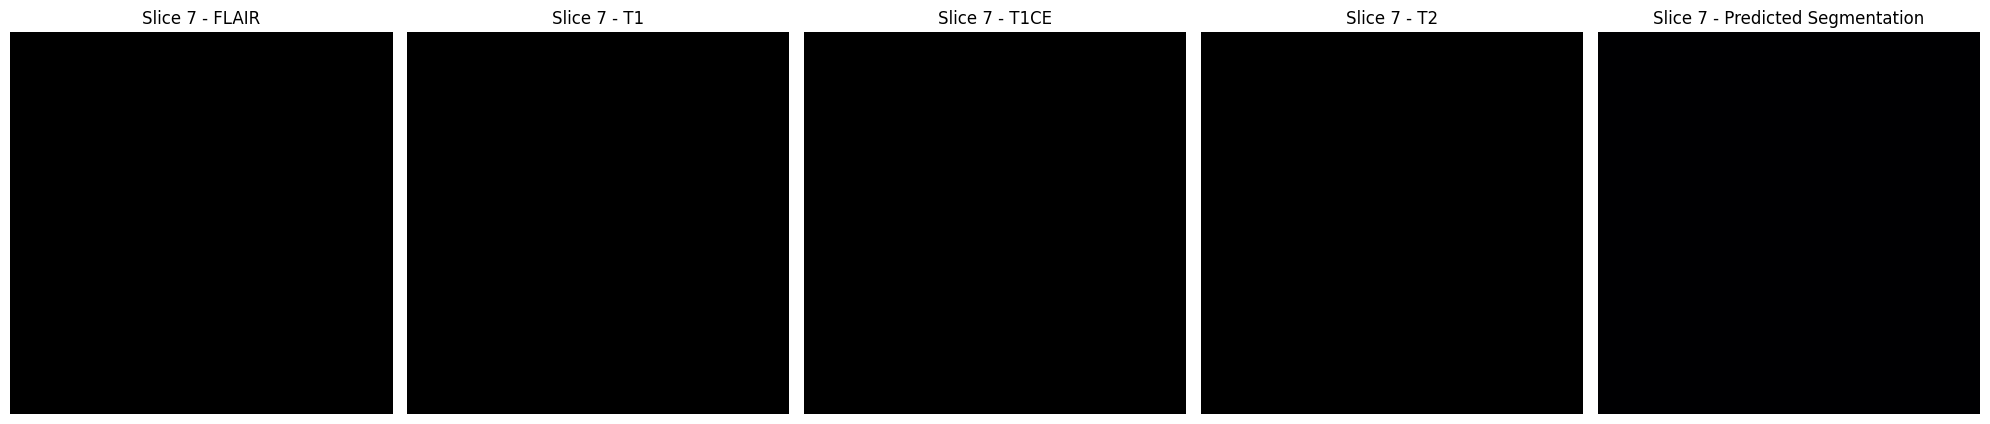

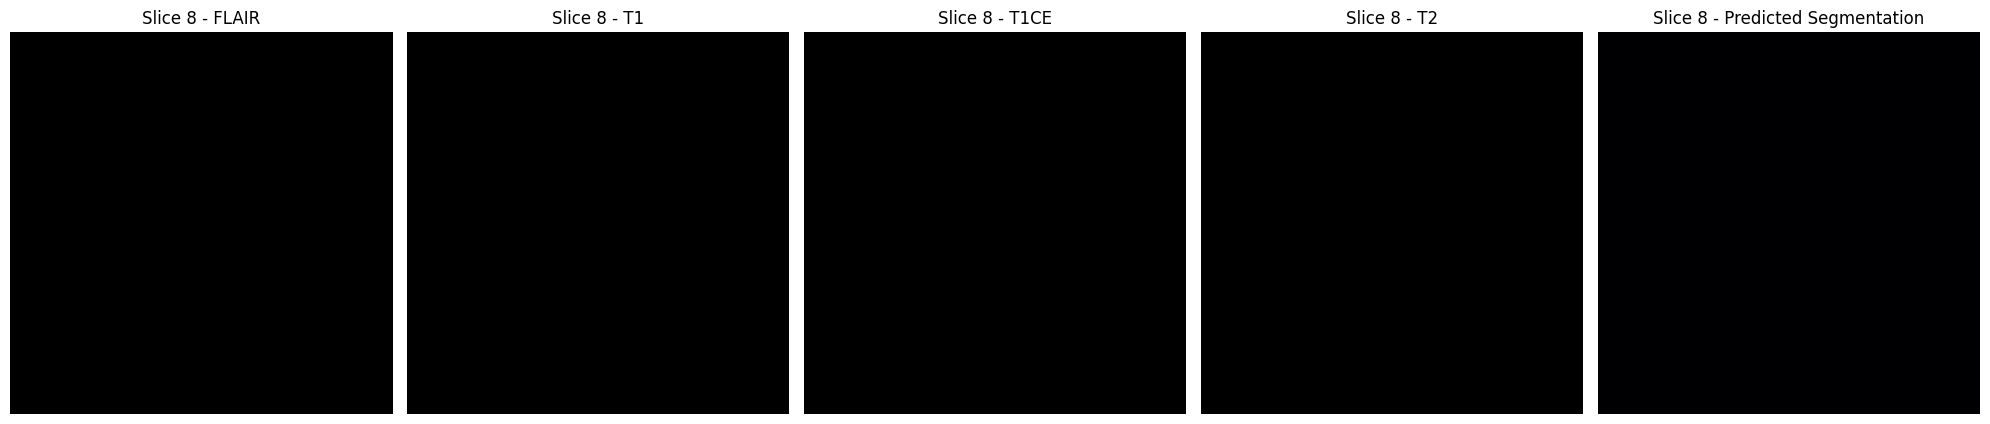

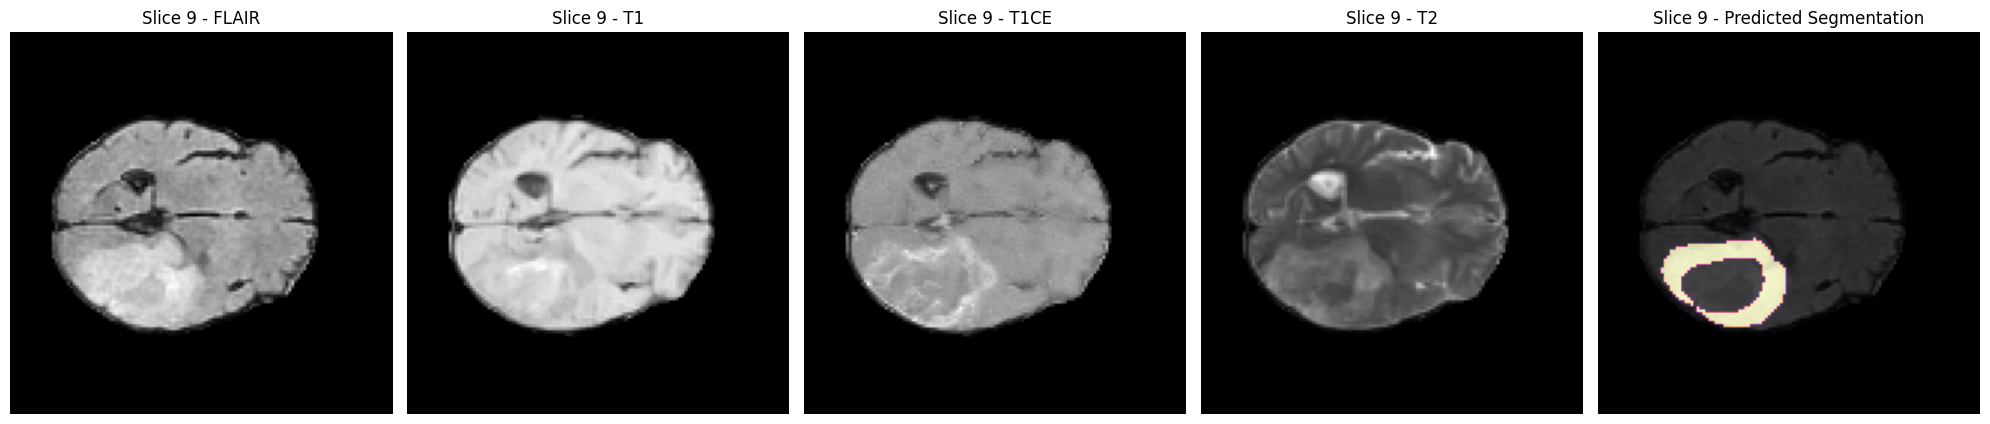

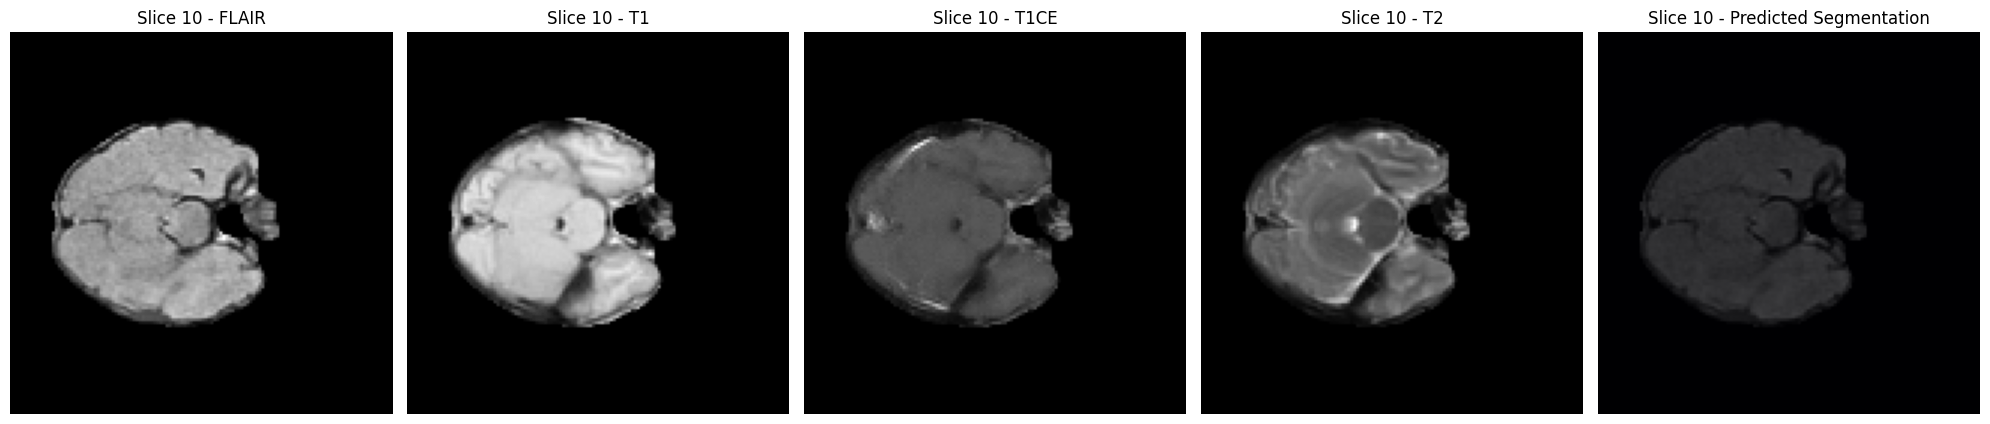

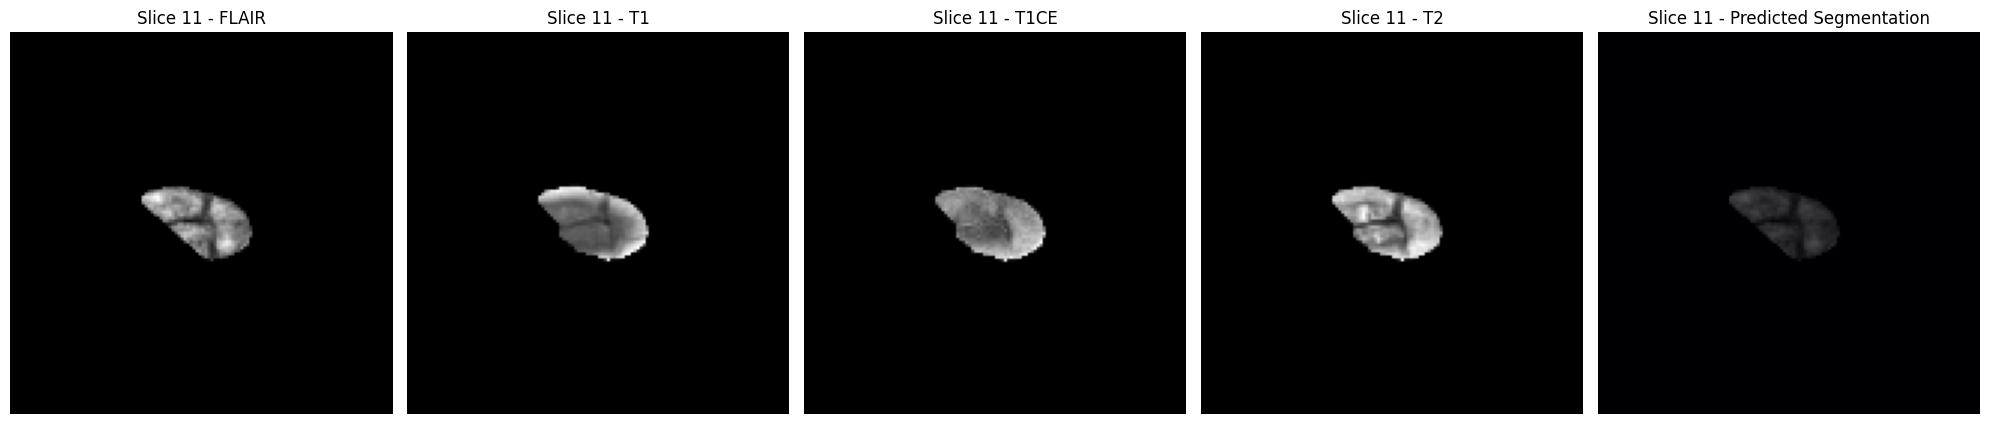

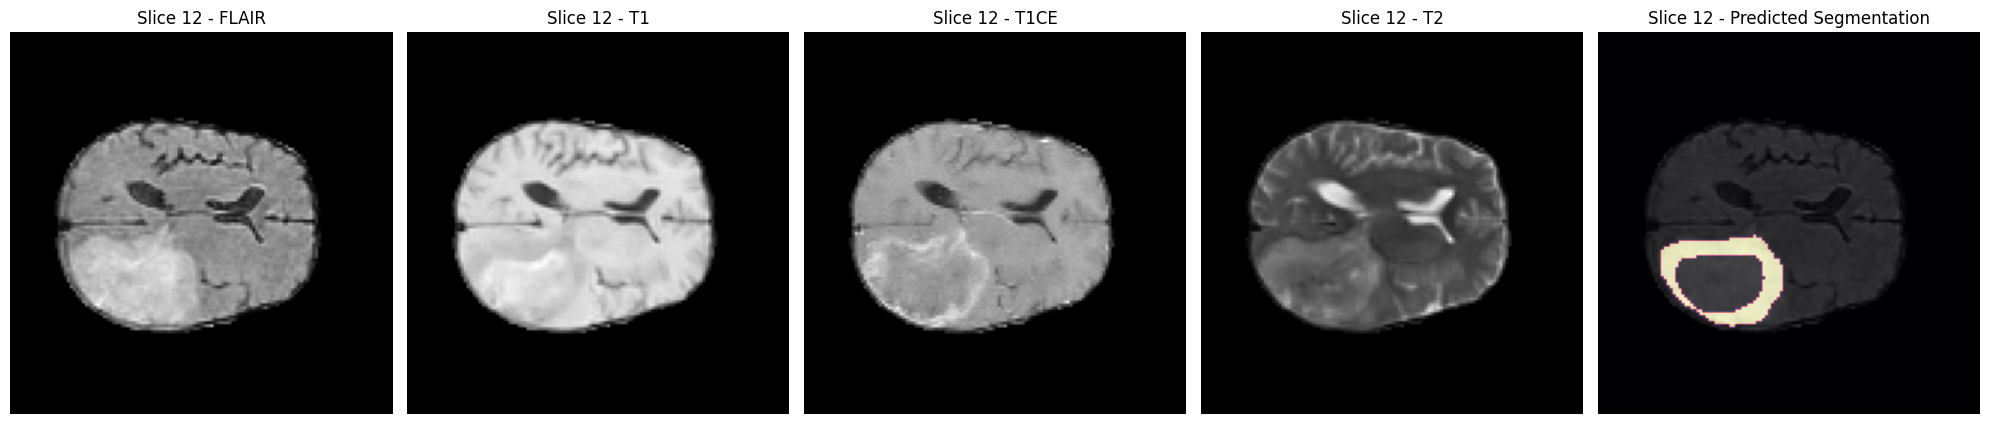

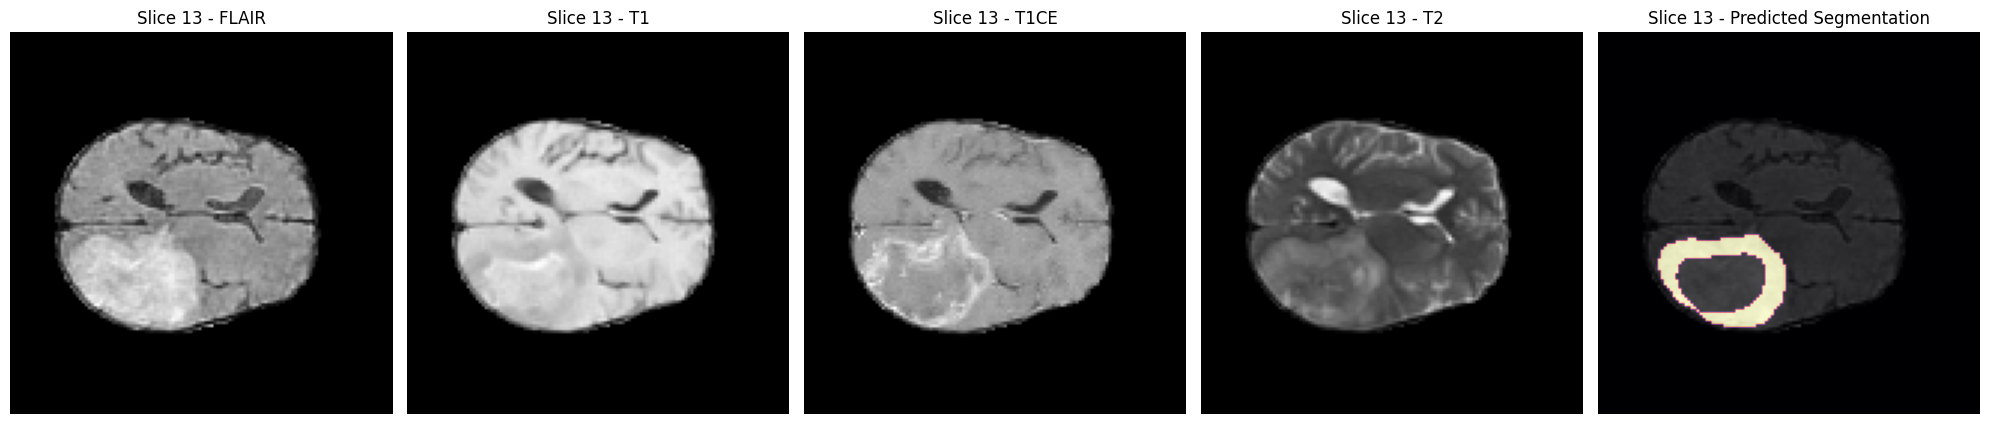

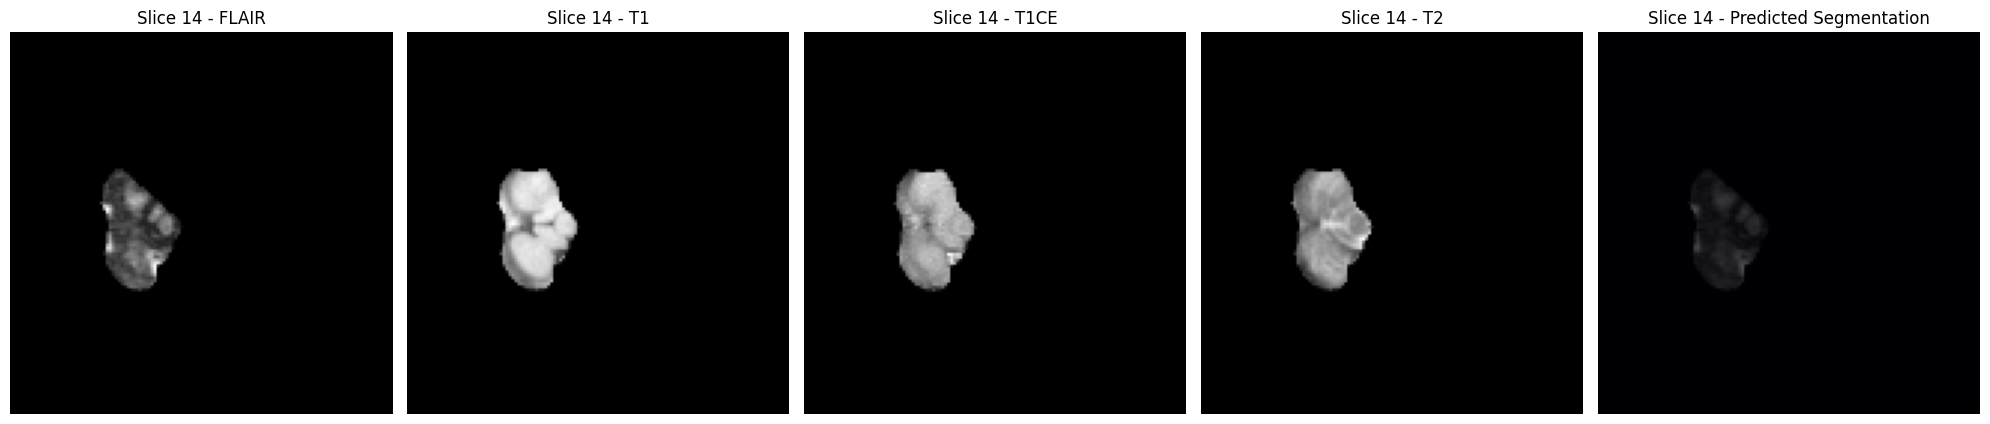

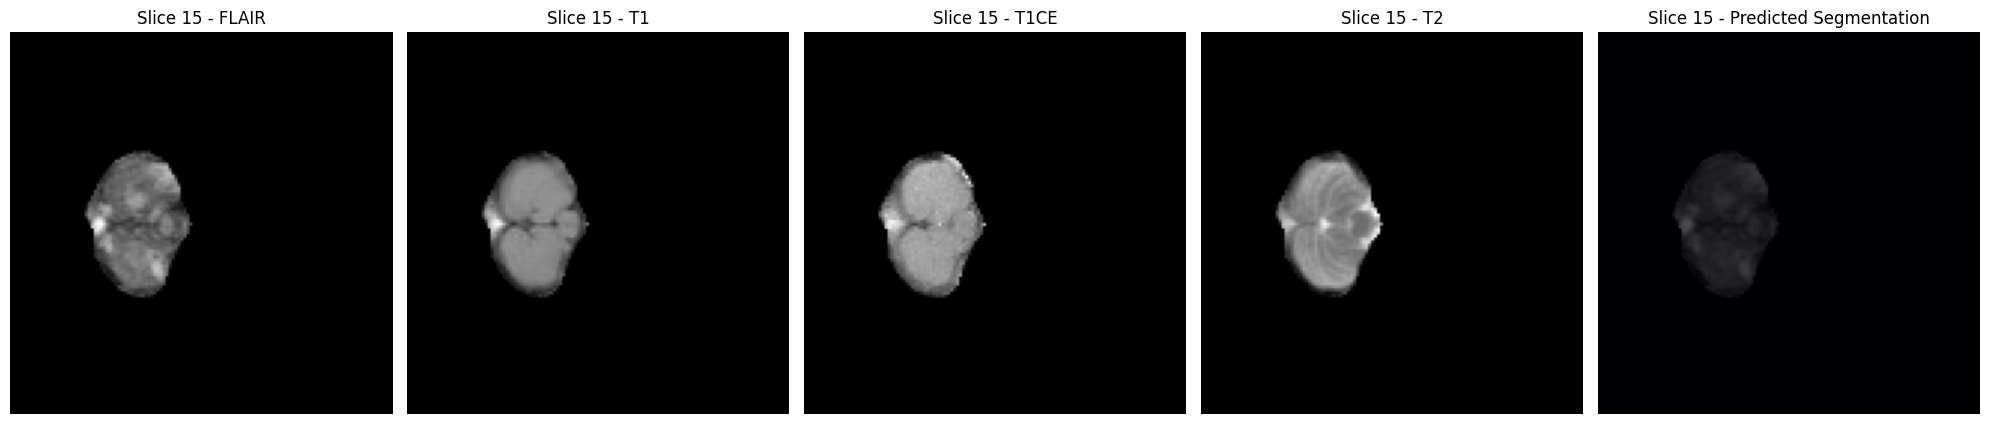

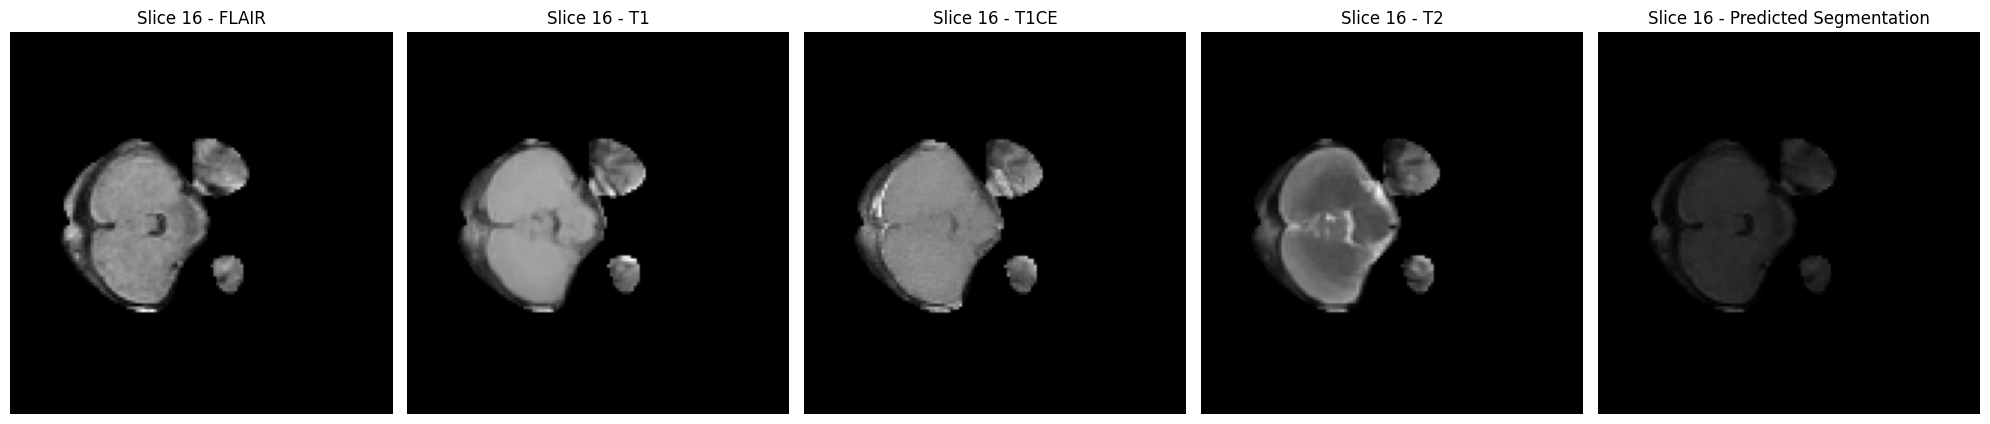

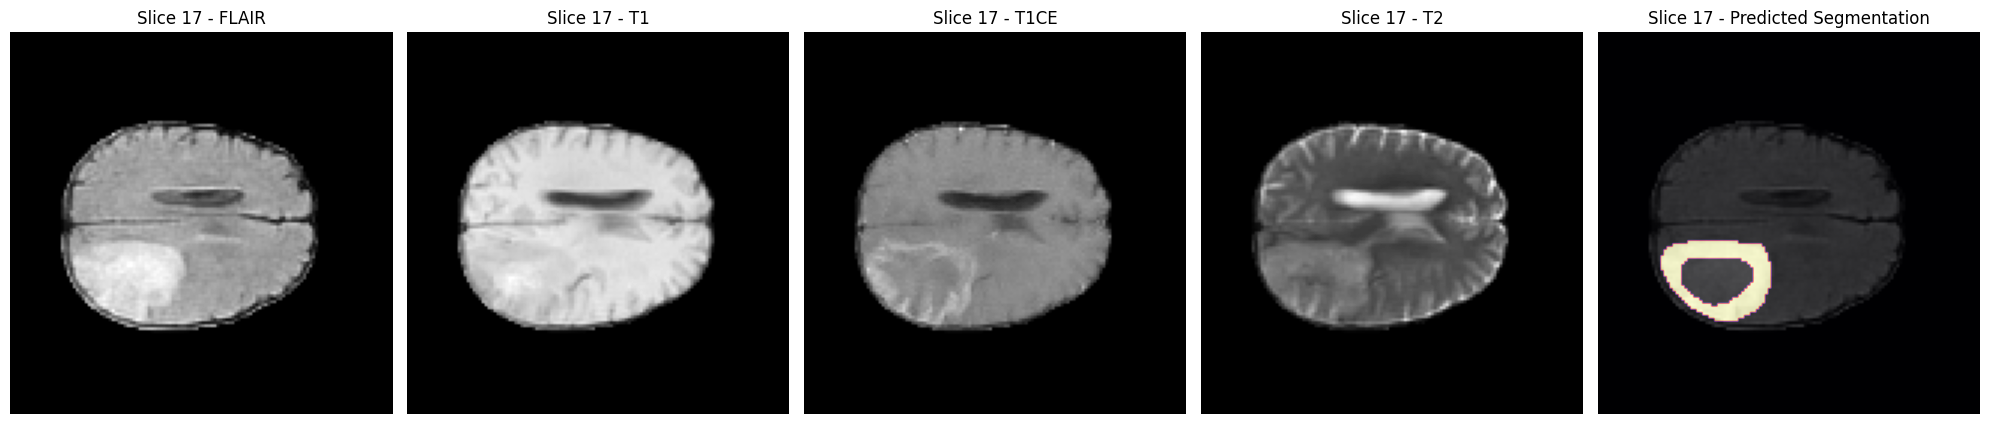

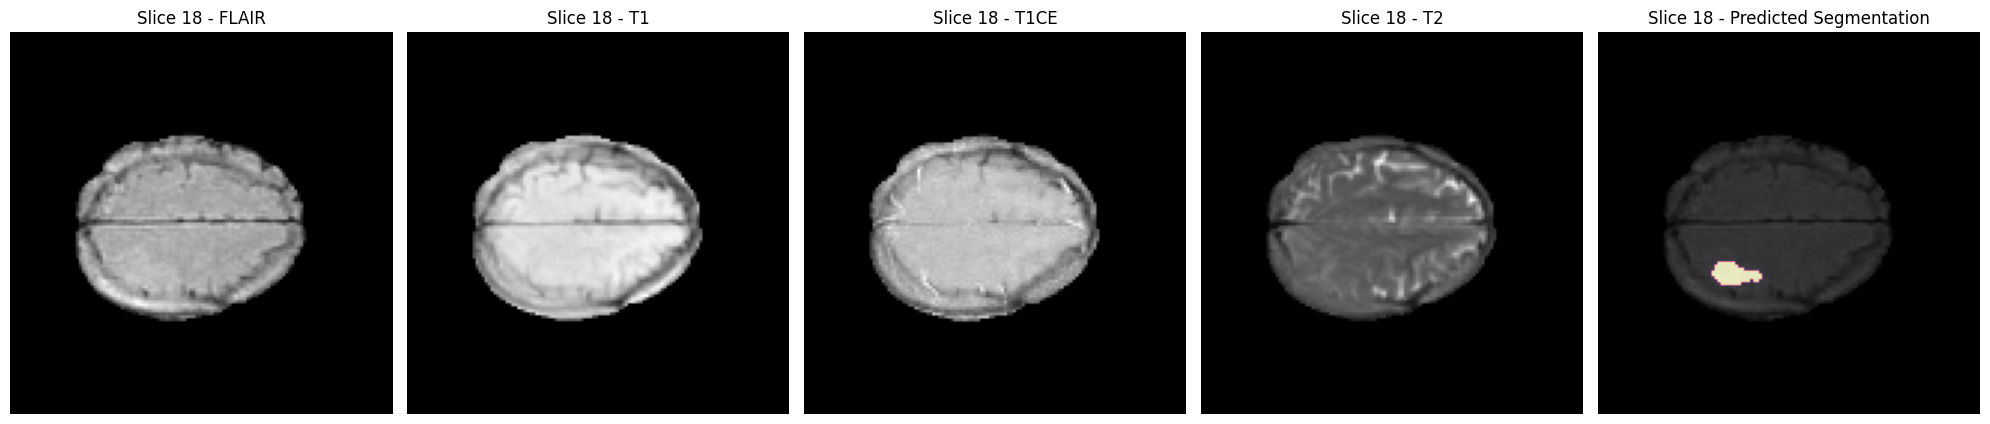

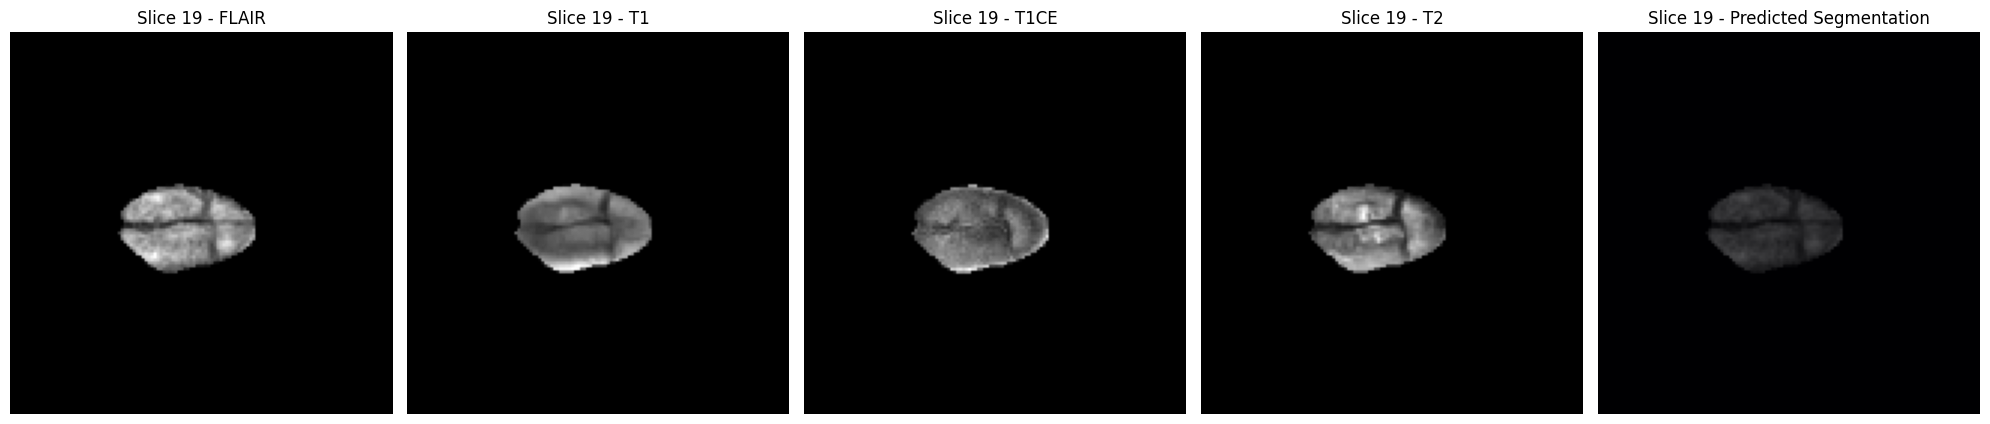

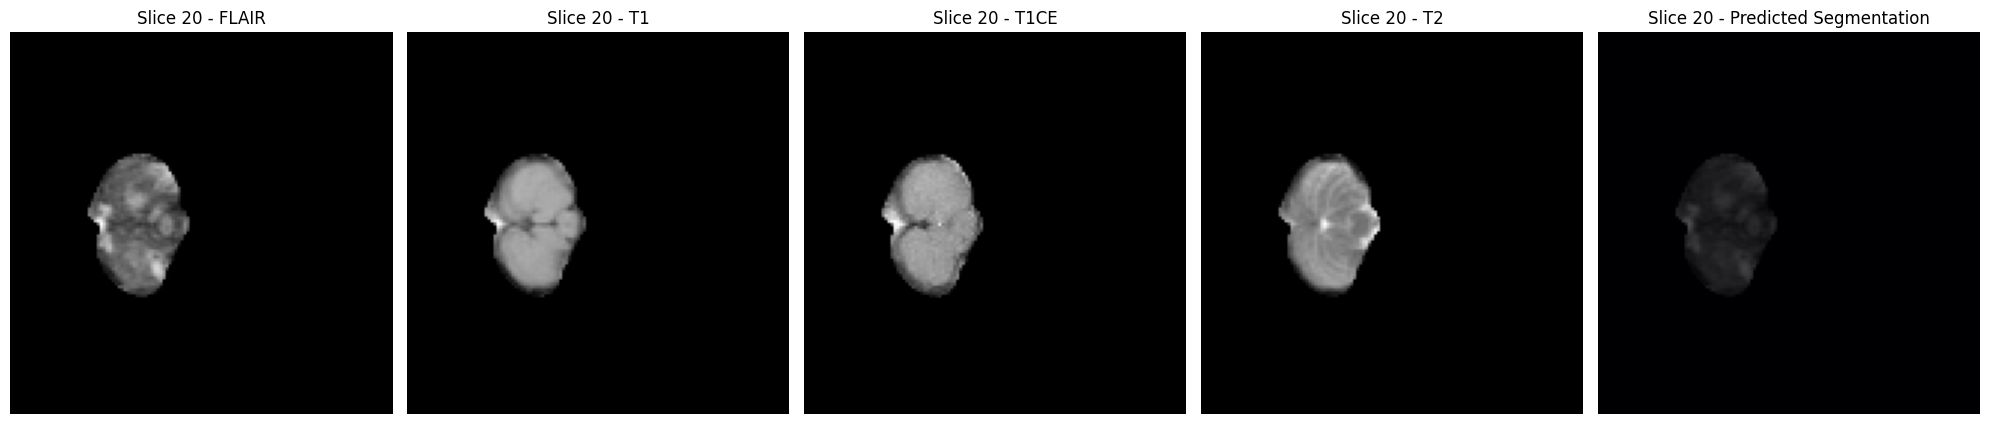

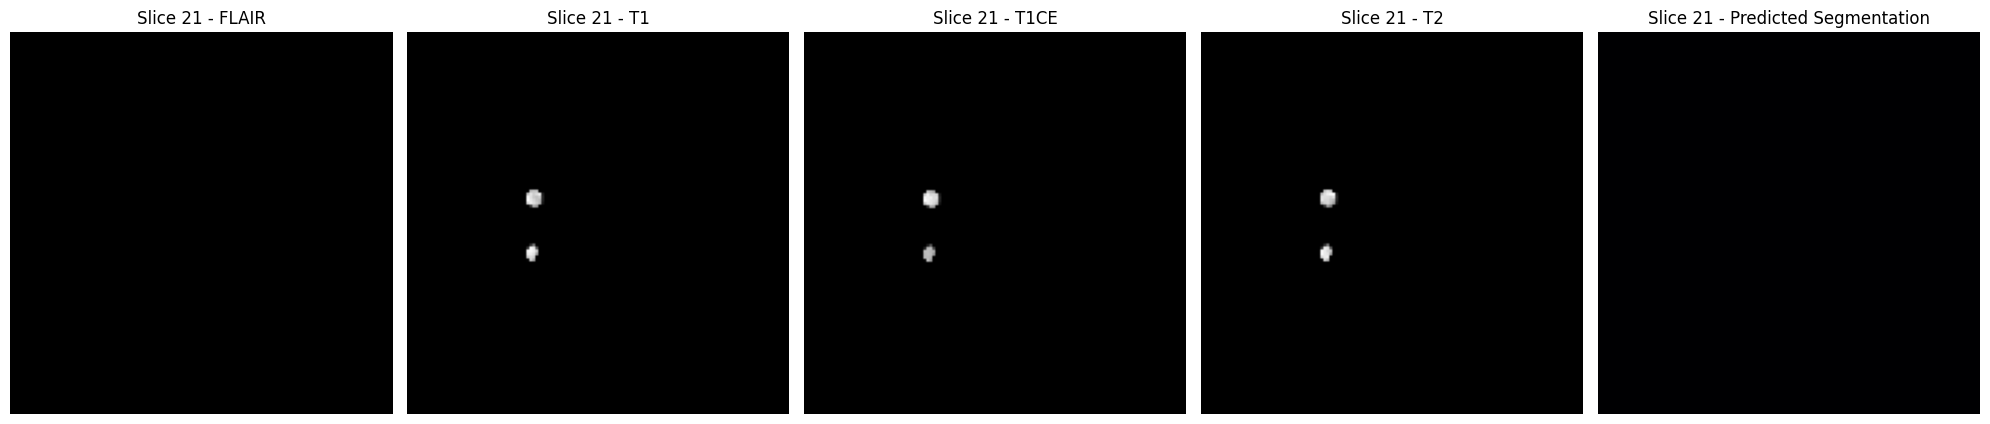

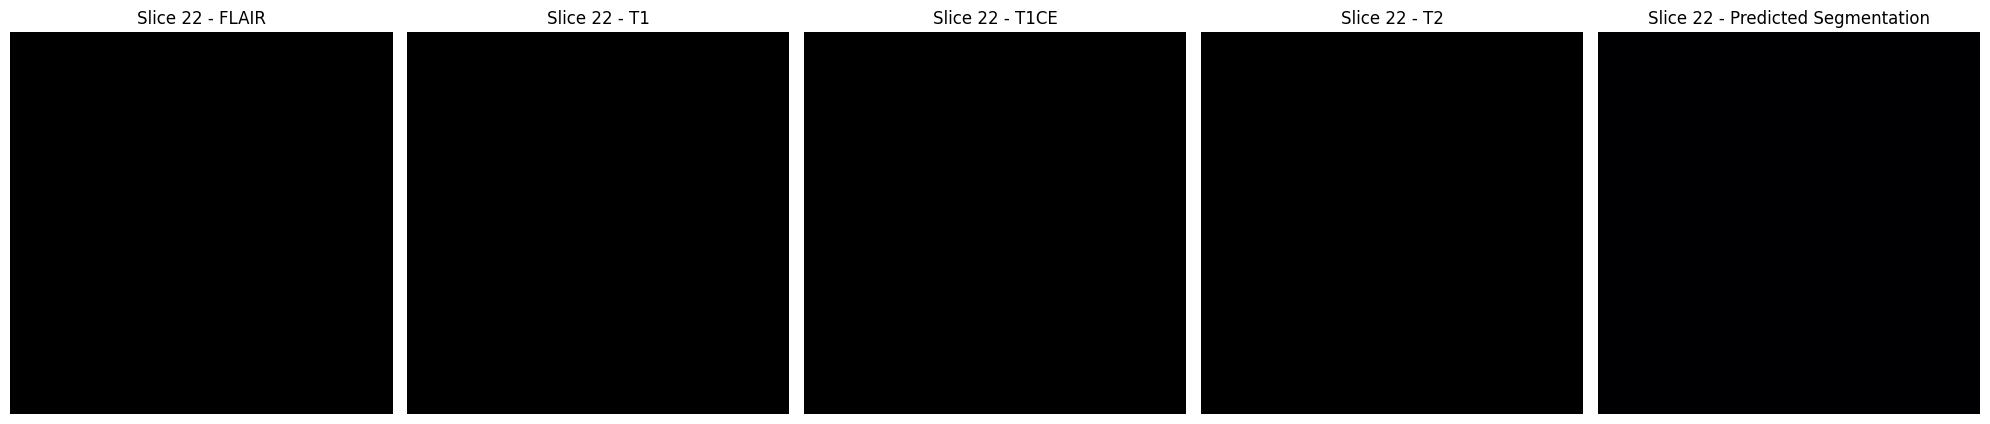

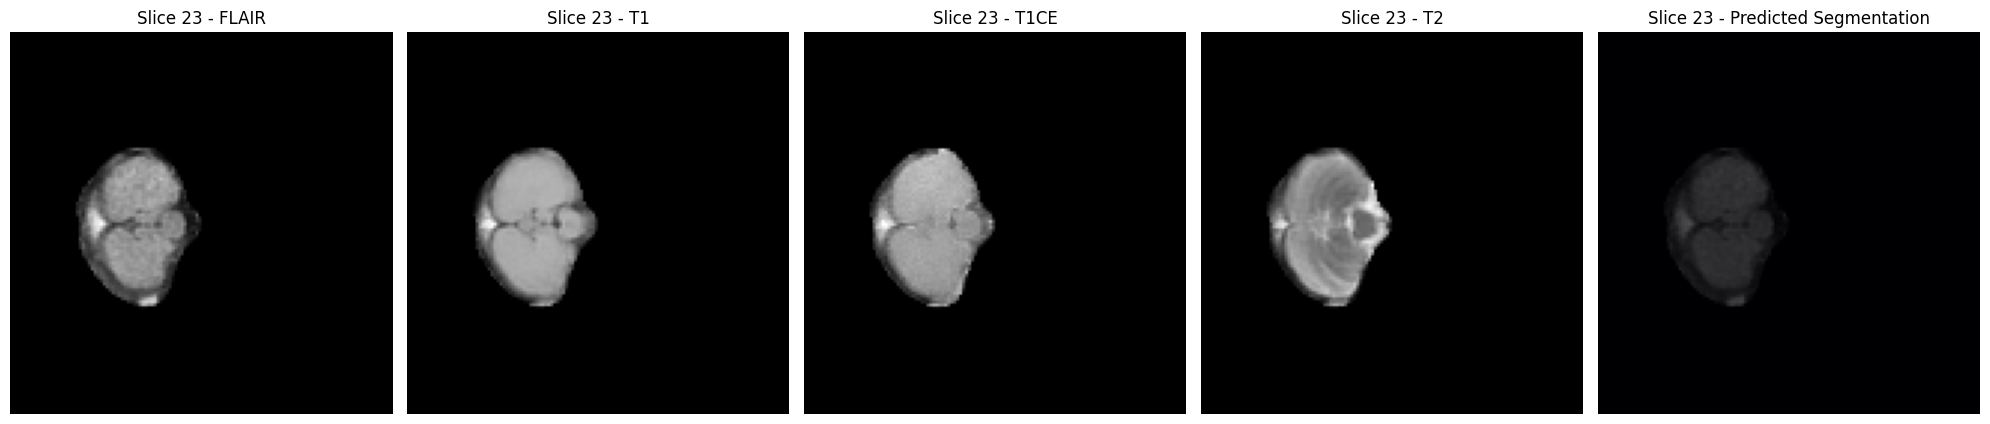

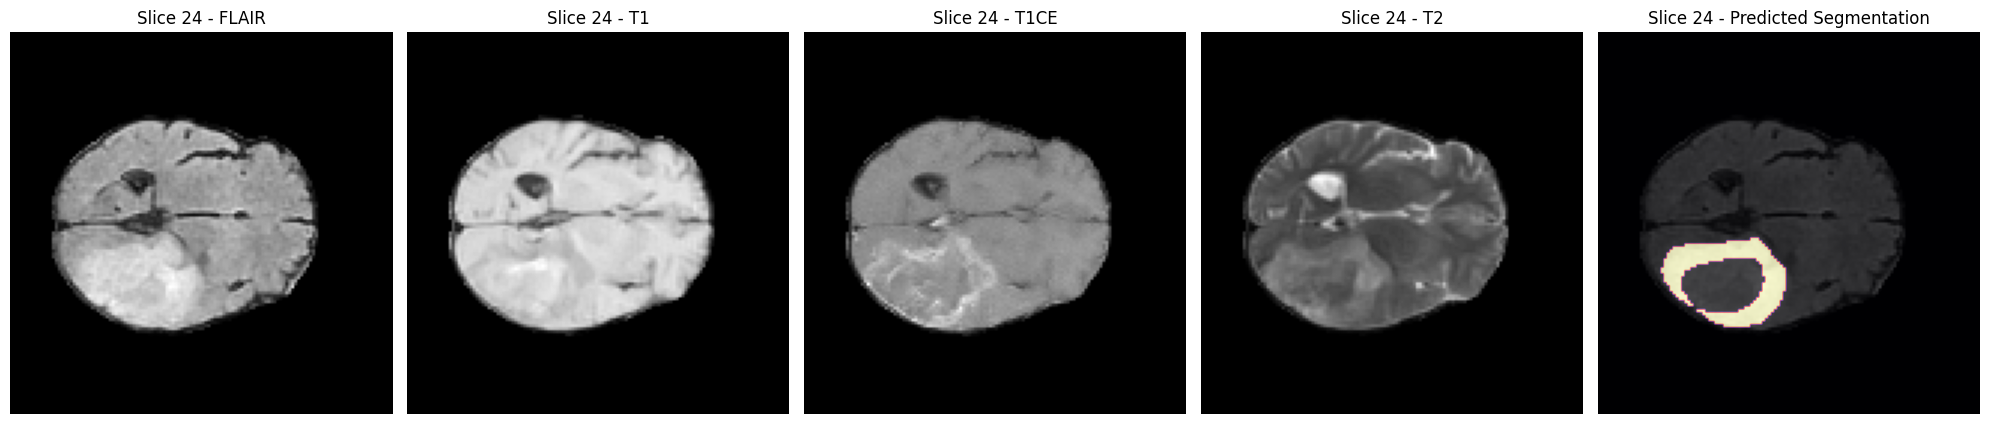

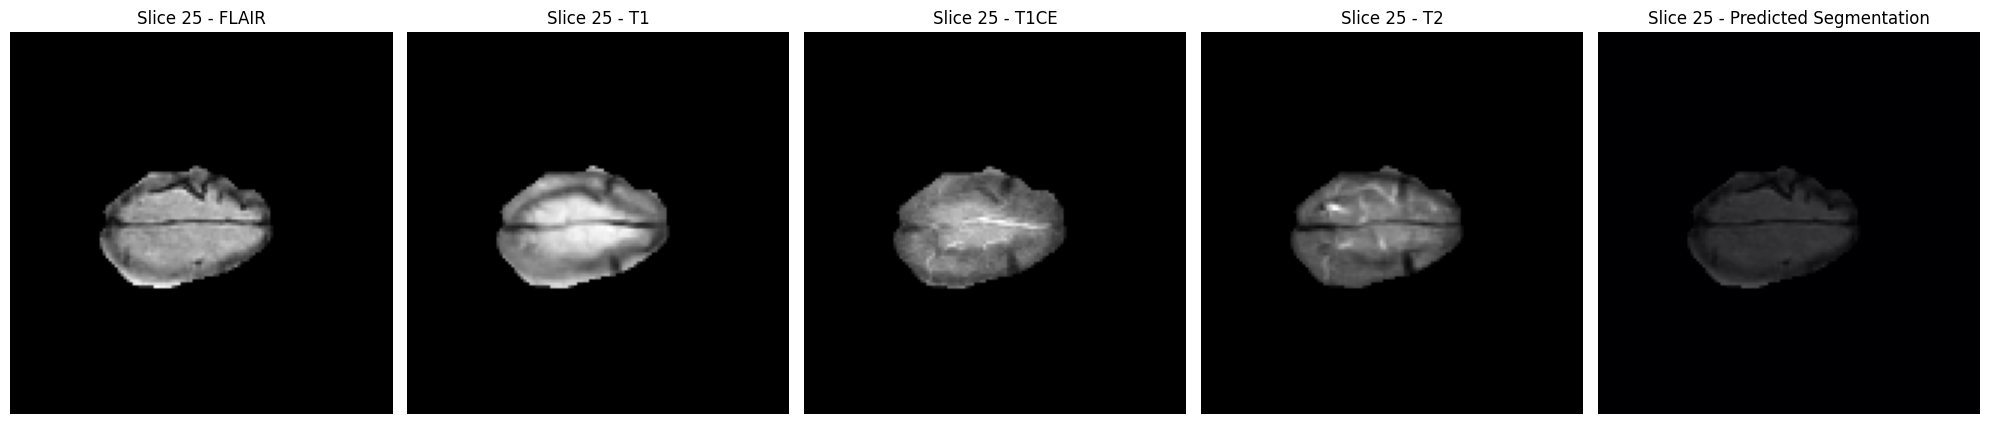

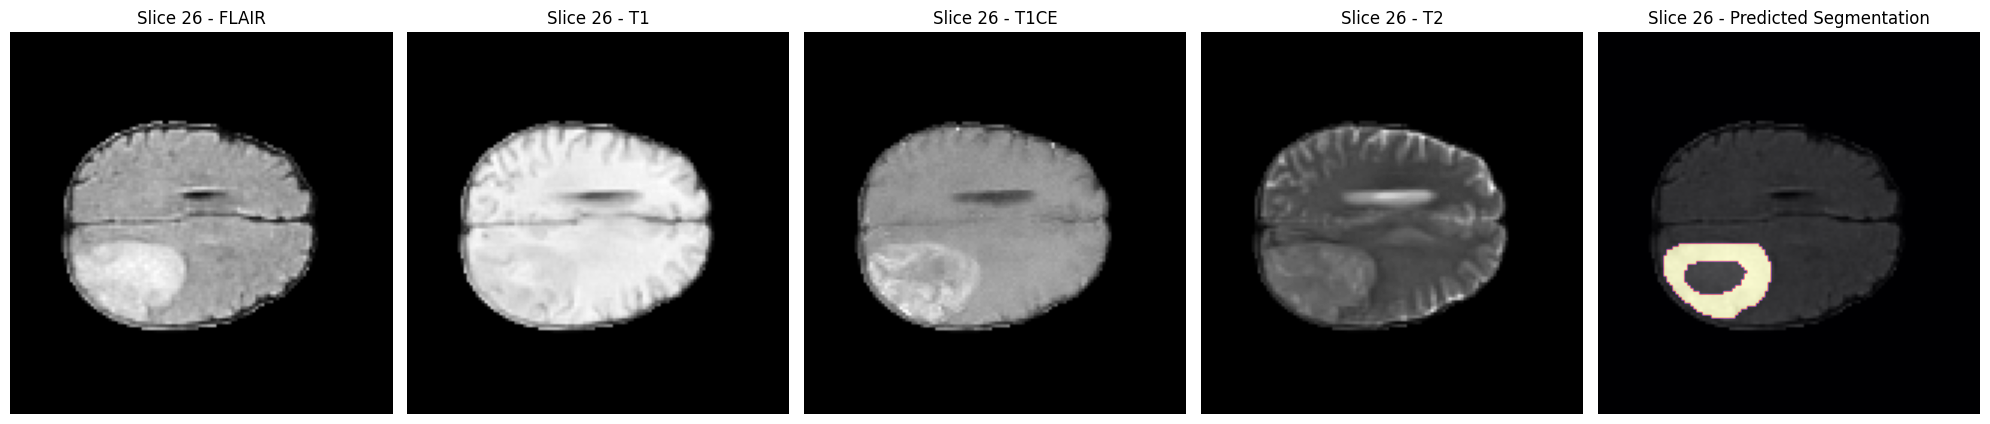

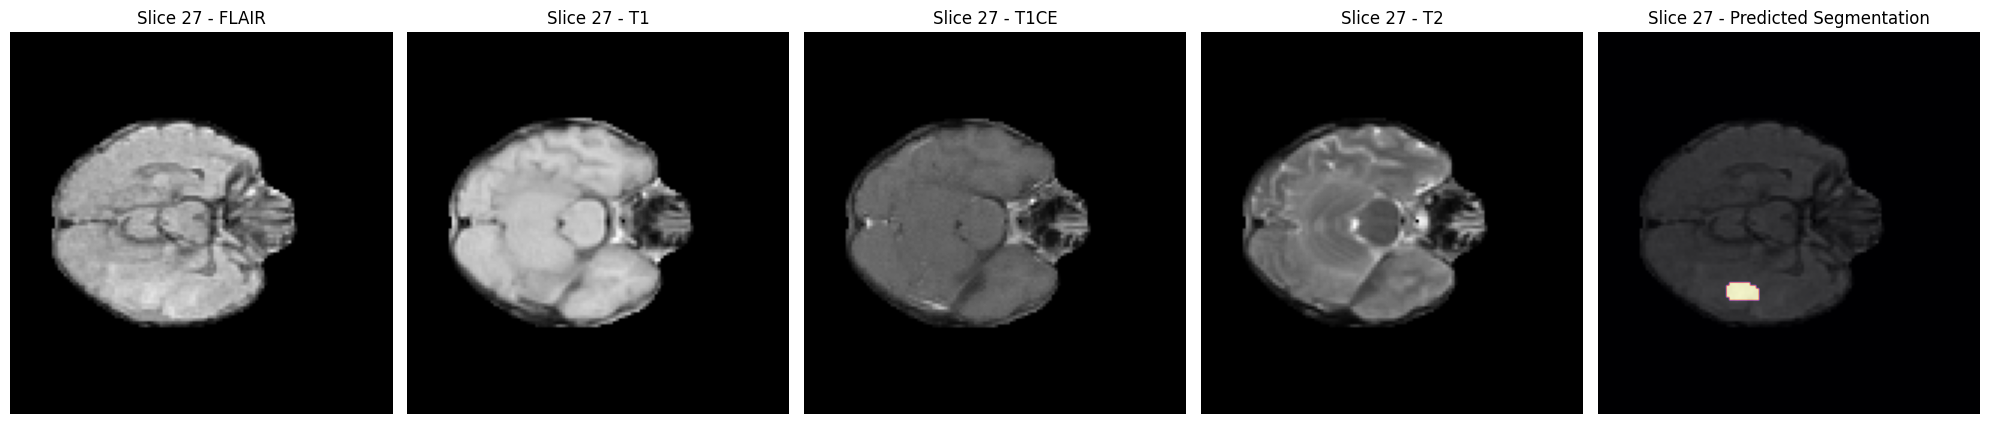

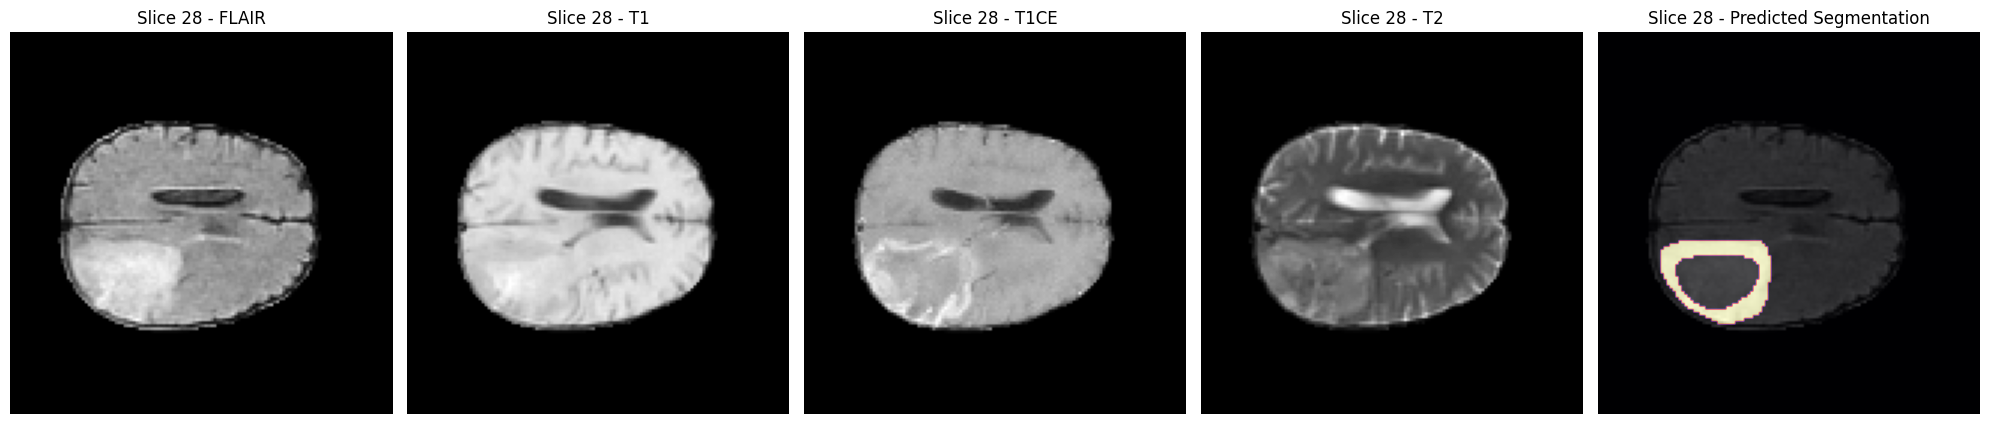

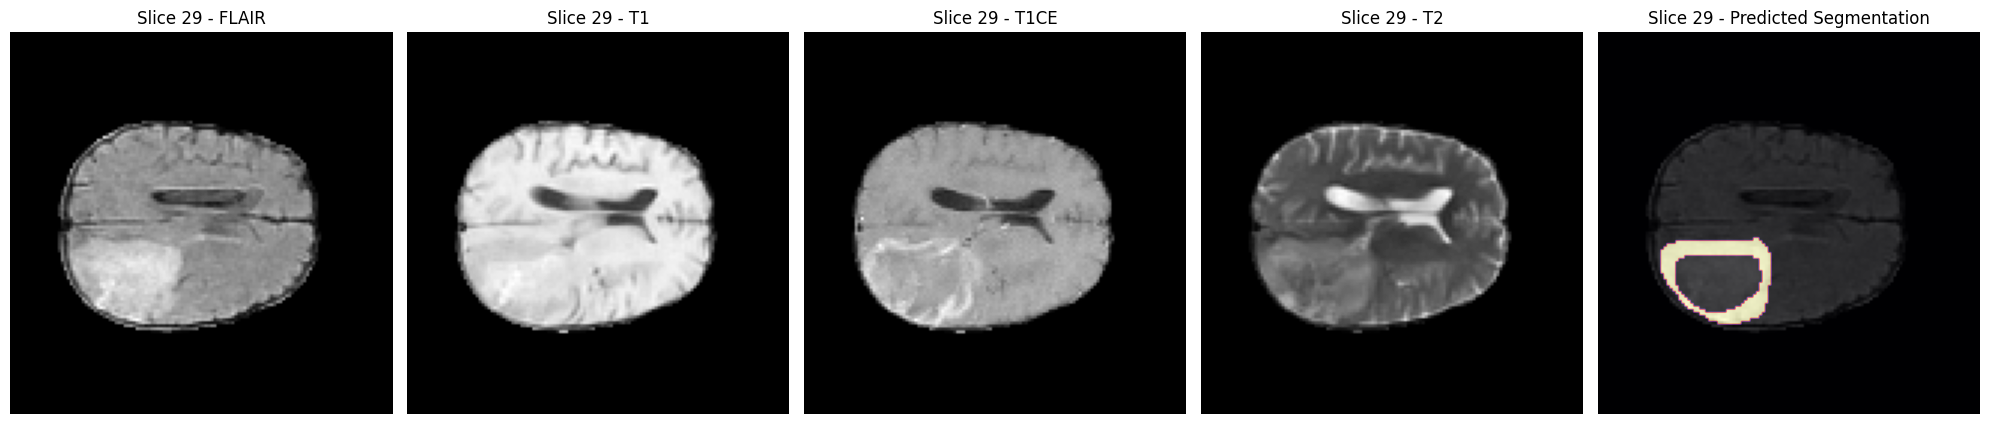

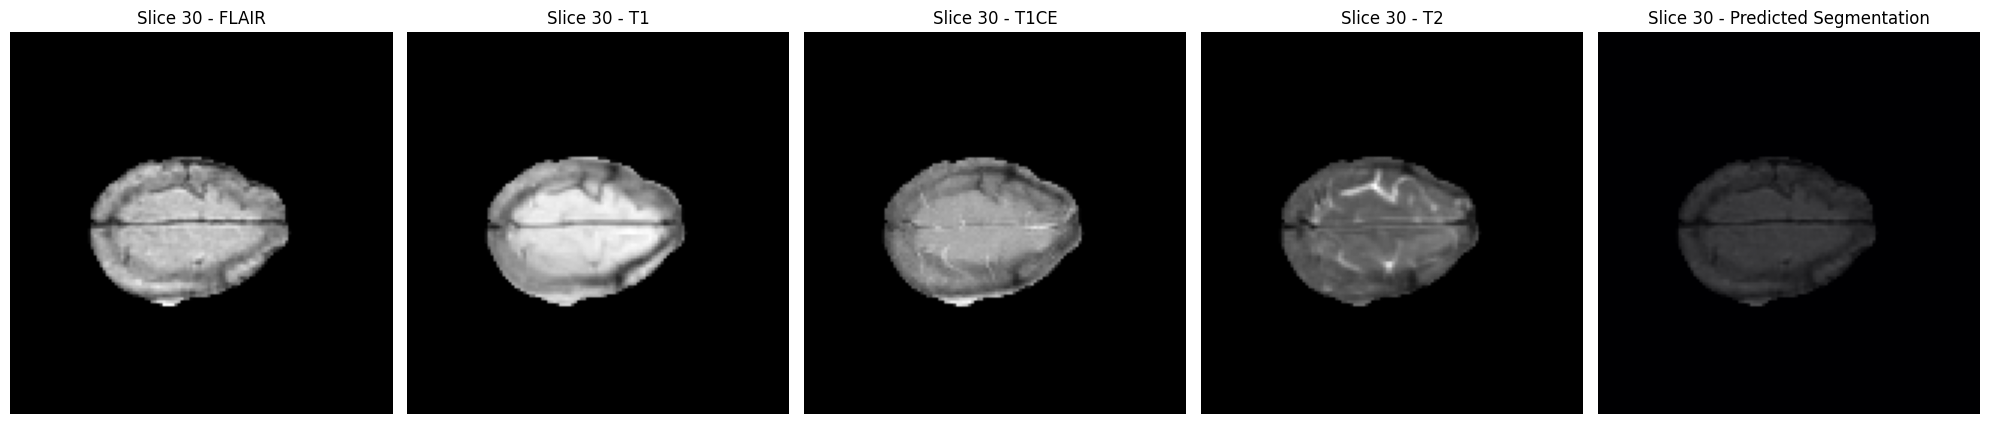

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
attention_unet_model = load_model("attention_enhanced_unet_model1.h5", compile=False)

def display_all_predictions(input_mri, ground_truth, predicted_mask):
    """
    Display predictions for the entire test set across all modalities and slices.

    Parameters:
    - input_mri: Input MRI data (4D array with shape [slices, height, width, channels]).
    - ground_truth: Ground truth segmentation masks (4D array).
    - predicted_mask: Predicted segmentation masks (4D array).
    """
    num_slices = input_mri.shape[0]

    for idx in range(num_slices):
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))

        # FLAIR channel
        axes[0].imshow(input_mri[idx, :, :, 0], cmap='gray')
        axes[0].set_title(f'Slice {idx} - FLAIR')
        axes[0].axis('off')

        # T1 channel
        axes[1].imshow(input_mri[idx, :, :, 2], cmap='gray')
        axes[1].set_title(f'Slice {idx} - T1')
        axes[1].axis('off')

        # T1CE channel
        axes[2].imshow(input_mri[idx, :, :, 1], cmap='gray')
        axes[2].set_title(f'Slice {idx} - T1CE')
        axes[2].axis('off')

        # T2 channel
        axes[3].imshow(input_mri[idx, :, :, 3], cmap='gray')
        axes[3].set_title(f'Slice {idx} - T2')
        axes[3].axis('off')

        # Predicted segmentation mask
        axes[4].imshow(input_mri[idx, :, :, 0], cmap='gray')  # Display input as background (e.g., FLAIR)
        axes[4].imshow(predicted_mask[idx, :, :, 0], cmap='magma', alpha=0.7)  # Overlay predicted mask
        axes[4].set_title(f'Slice {idx} - Predicted Segmentation')
        axes[4].axis('off')

        plt.tight_layout()
        plt.show()

# Generate predictions for the entire test data (assuming you have X_test and Y_test)
predicted_masks = attention_unet_model.predict(X_val)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Binarize predictions

# Display predictions for the entire test data
display_all_predictions(X_val, Y_val, predicted_masks)
